In [1]:
import pandas as pd 
import numpy as np

#import необходимых модулей

from sklearn.model_selection import train_test_split, TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

%matplotlib inline

In [2]:
def inc_first_transfrow(df):
    # Incorporate first row into columns' names
    df.columns = df.iloc[0,:].fillna('v').values + "_" + df.columns 
    df = df.iloc[1:]
    return df 

def WMSFE(y_true, y_pred, dfs_all_cols_dictionary):
    wmsfe_cols = []
    # Computing overall number of predictions
    K = sum(map(len, y_pred))
    # Making matrix of H valus for every column
    H = np.array([np.array(range(1, len(y_pred_i)+1)) for y_pred_i in y_pred])
    # Computing variance for every column
    D = []
    for key, val in dfs_all_cols_dictionary.items():
        if key == 'Monthly': period=12
        else: period=4
        D.append(np.var(val.diff(period).dropna().T.values, axis=1))
    D = np.concatenate(D)
    for _col_i in range(len(y_pred)):
        wmsfe_cols.append((y_true[_col_i]-y_pred[_col_i])**2 / (H[_col_i]*D[_col_i]))
    wmsfe = np.sum(wmsfe_cols) /  K   
    return wmsfe 

def radial_basis(x, month, alpha):
    alpha = alpha
    coef = -1/(2*alpha)
    return np.exp(coef*(x-month)**2)

In [3]:
train = pd.ExcelFile('data/Train.xlsx')
train_m = train.parse('Monthly', index_col=0, na_values='Forecast')
train_q = train.parse('Quarterly', index_col=0, na_values='Forecast')
del train

train_m = inc_first_transfrow(train_m).astype(float) 
train_q = inc_first_transfrow(train_q).astype(float)

In [7]:
train_m.describe()

v_Диффузный индекс цен на выпускаемую продукцию, ожидаемые изменения   \
count                                         156.000000                       
mean                                           70.275641                       
std                                             8.230215                       
min                                            52.000000                       
25%                                            64.750000                       
50%                                            70.000000                       
75%                                            76.000000                       
max                                            89.000000                       

       v_Диффузный индекс цен на покупаемую продукцию, ожидаемые изменения   \
count                                         156.000000                      
mean                                           85.628205                      
std                                             6.009904                      
min                                            69.000000                      
25%                                            81.750000                      
50%                                            85.500000                      
75%                                            90.250000                      
max                                            98.000000                      

       v_Диффузный индекс заработной платы, ожидаемые изменения   \
count                                          156.00000           
mean                                            63.50000           
std                                              9.46675           
min                                             38.00000           
25%                                             57.00000           
50%                                             64.00000           
75%                                             71.00000           
max                                             80.00000           

       v_Диффузный индекс занятости, ожидаемые изменения   \
count                                         156.000000    
mean                                           43.179487    
std                                             6.015557    
min                                            24.000000    
25%                                            40.000000    
50%                                            43.000000    
75%                                            47.250000    
max                                            56.000000    

       v_Диффузный индекс выпуска, ожидаемые изменения   \
count                                        156.000000   
mean                                          52.852564   
std                                           10.934883   
min                                           21.000000   
25%                                           45.000000   
50%                                           54.000000   
75%                                           61.000000   
max                                           73.000000   

       v_Диффузный индекс закупок оборудования, ожидаемые изменения   \
count                                         156.000000               
mean                                           34.333333               
std                                             6.230345               
min                                            18.000000               
25%                                            30.000000               
50%                                            35.000000               
75%                                            38.000000               
max                                            48.000000               

       v_Диффузный индекс финансового состояния, ожидаемые изменения   \
count                                         156.000000                
mean                                           54.596154                
std        

In [8]:
train_q.describe()

ln_ВВП, млрд  ln_Реальный ВВП  ln_ВВП A, млрд.руб.  \
count     52.000000        52.000000            52.000000   
mean       9.244955         0.362354             5.659078   
std        0.566434         0.146351             0.740594   
min        8.041233         0.000000             4.273602   
25%        8.825932         0.270024             5.079341   
50%        9.324399         0.391307             5.685815   
75%        9.741472         0.467115             6.260549   
max       10.046713         0.597999             7.165638   

       ln_ВВП B, млрд.руб.  ln_ВВП C, млрд.руб.  ln_ВВП D, млрд.руб.  \
count            52.000000            52.000000            52.000000   
mean              3.034289             6.671732             7.145562   
std               0.414295             0.650946             0.527906   
min               2.480033             5.133081             5.926435   
25%               2.689455             6.329448             6.845814   
50%               2.936335             6.762117             7.204609   
75%               3.326336             7.237202             7.568053   
max               4.005985             7.581304             8.029572   

       ln_ВВП E, млрд.руб.  ln_ВВП F, млрд.руб.  ln_ВВП G, млрд.руб.  \
count            52.000000            52.000000            52.000000   
mean              5.615418             6.330177             7.375588   
std               0.588042             0.690026             0.507704   
min               4.357089             4.884884             6.374866   
25%               5.157313             5.765828             6.997412   
50%               5.704755             6.466092             7.499223   
75%               6.071053             6.922694             7.807231   
max               6.518491             7.536249             8.072115   

       ln_ВВП H, млрд.руб.  ...  ln_Реальный ВВП K  ln_Реальный ВВП L  \
count            52.000000  ...          52.000000          52.000000   
mean              4.374676  ...           0.422317           0.098968   
std               0.608349  ...           0.245585           0.053120   
min               2.944192  ...          -0.087127          -0.025185   
25%               3.899968  ...           0.203324           0.066058   
50%               4.515173  ...           0.496044           0.108019   
75%               4.862251  ...           0.624930           0.135630   
max               5.189876  ...           0.779464           0.182750   

       ln_Реальный ВВП M  ln_Реальный ВВП N  ln_Реальный ВВП O  \
count          52.000000          52.000000          52.000000   
mean           -0.005949           0.085078           0.189211   
std             0.041822           0.053416           0.099194   
min            -0.078568           0.000000           0.000000   
25%            -0.041670           0.042093           0.133589   
50%            -0.005276           0.080797           0.158773   
75%             0.021546           0.111491           0.225308   
max             0.077546           0.227901           0.485755   

       ln_Реальные налоги на продукты  ln_Реальные субсидии на продукты  \
count                       52.000000                         52.000000   
mean                         0.331678                         -0.261055   
std                          0.134806                          0.221111   
min                          0.000000                         -0.616826   
25%                          0.242905                         -0.427757   
50%                          0.365127                         -0.284468   
75%                          0.430409                         -0.103955   
max                          0.530615                          0.211227   

       ln_Инвестиции, собственные средства, млрд.руб.  \
count                                       52.000000   
mean                                         6.350054   
std                                          0.675265   
mi

# Строим трейн

In [759]:
def plot_every_col_m(df):
    ylines_x_grey = np.ravel([[f'{_y}m{_m:02d}' for _m in [3,6,9]] for _y in range(2003, 2016)])
    ylines_x_red = np.ravel([[f'{_y}m{_m:02d}' for _m in [12]] for _y in range(2003, 2016)])
    for _col in df.columns:
        to_plot = df.loc[:, _col]
        plt.figure(figsize=(16,4))
        plt.title(_col)
        xlabels = [val if (i+1)%3==0 else '' for i,val in enumerate(df.index) ]
        plt.xticks(ticks=range(0,len(xlabels)), 
                   labels=xlabels,
                   rotation=45)
        plt.plot(to_plot)
        [plt.axvline(x=_yline_x, c='grey') for _yline_x in ylines_x_grey]
        [plt.axvline(x=_yline_x, c='red') for _yline_x in ylines_x_red]
        plt.show()
        plt.hist(to_plot, bins=80)
        plt.show()

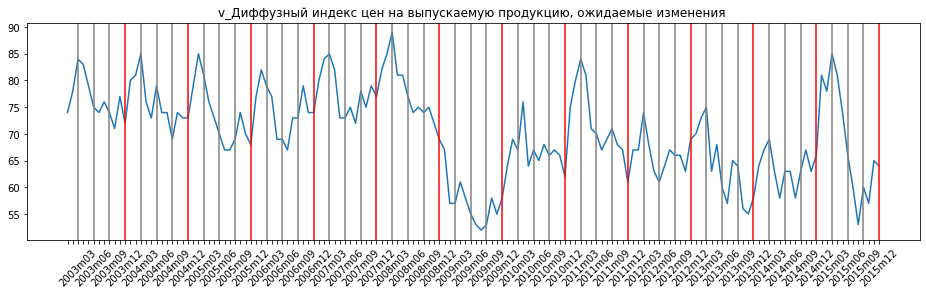

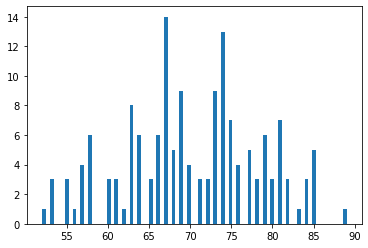

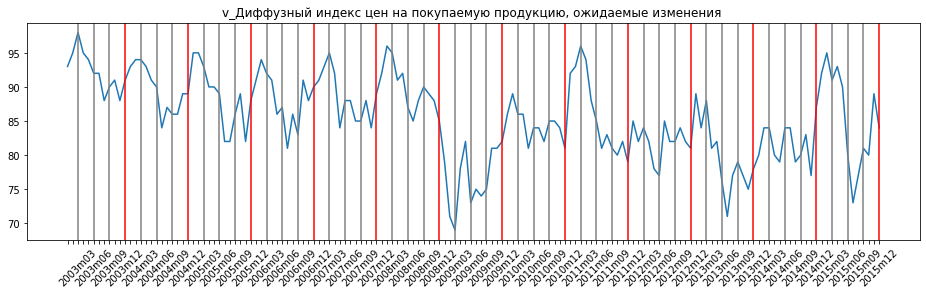

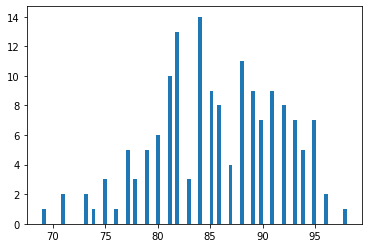

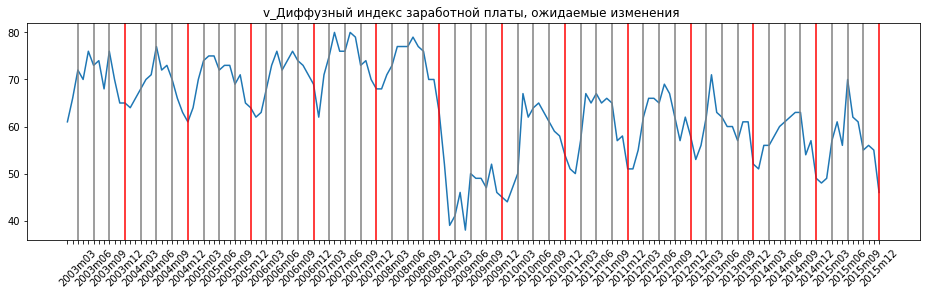

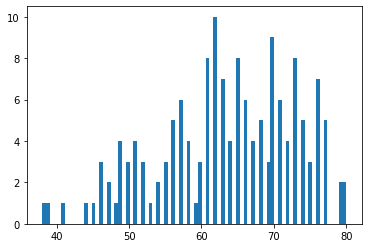

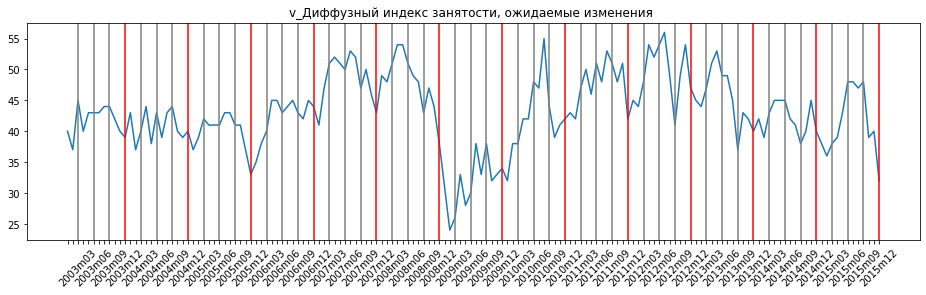

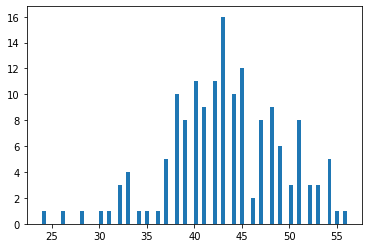

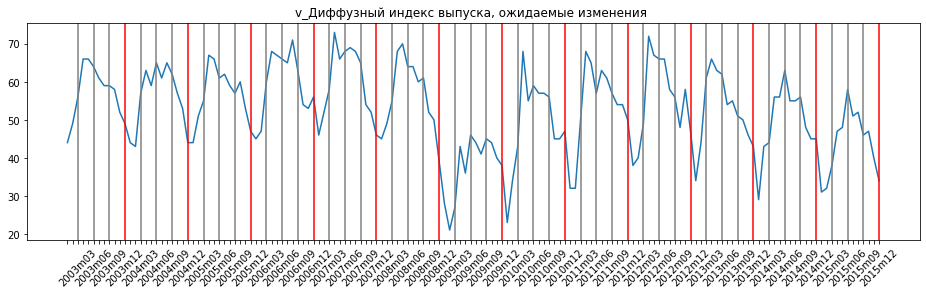

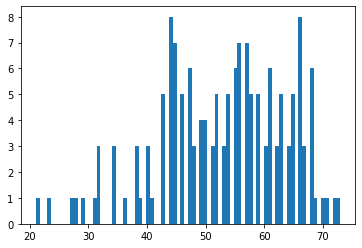

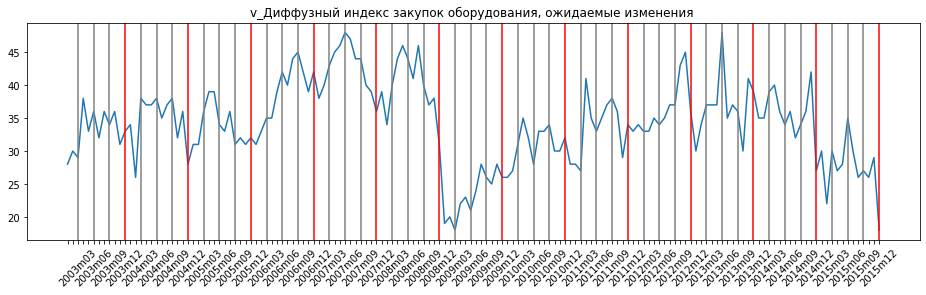

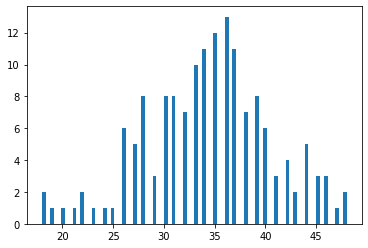

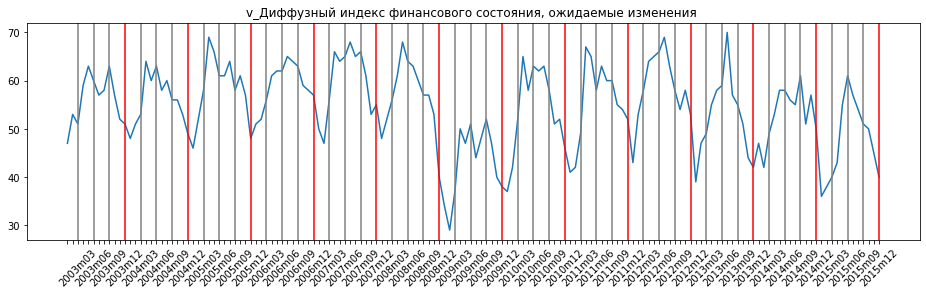

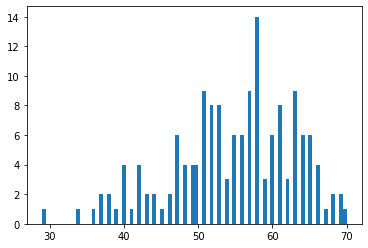

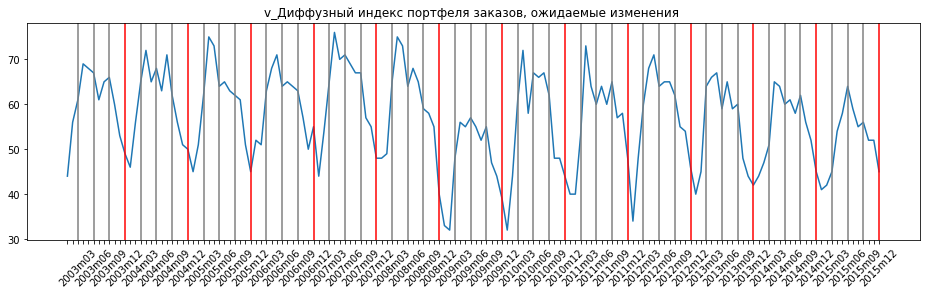

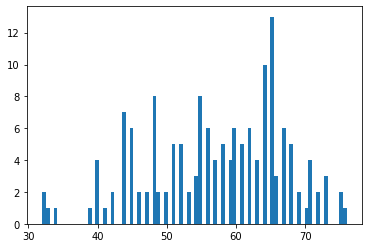

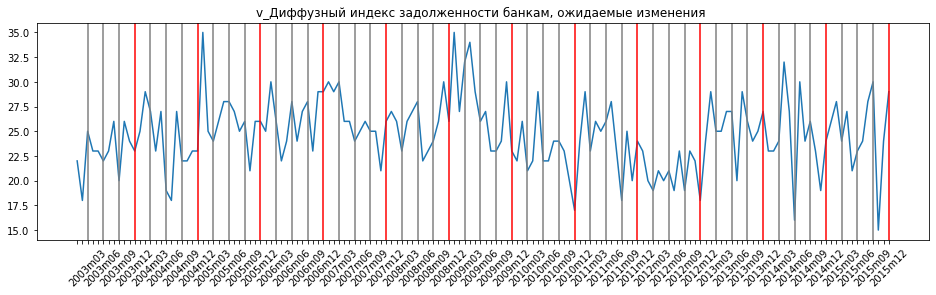

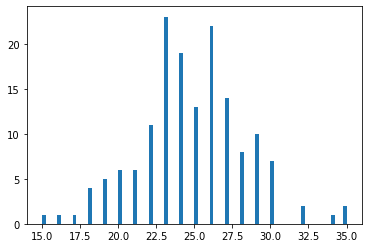

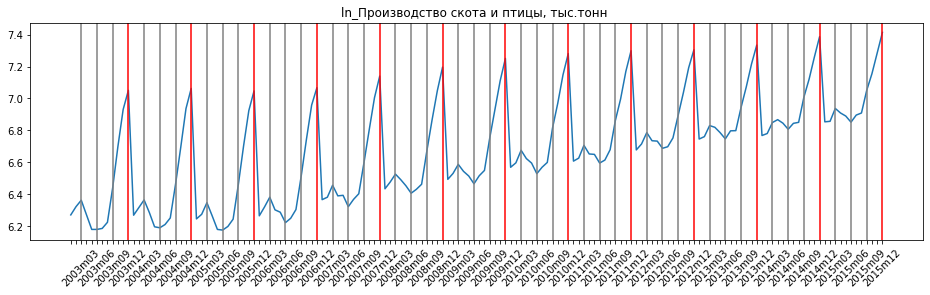

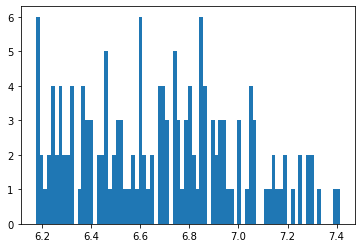

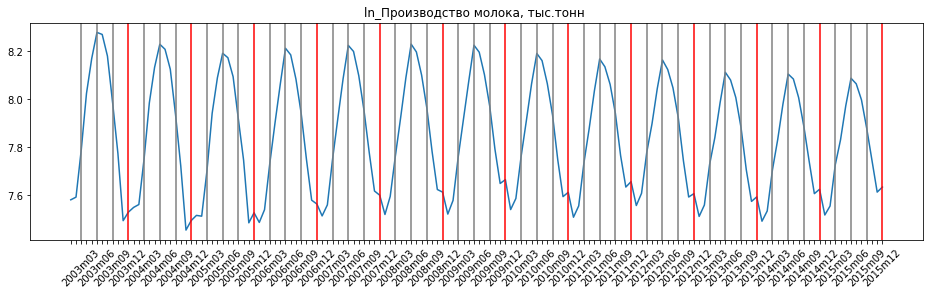

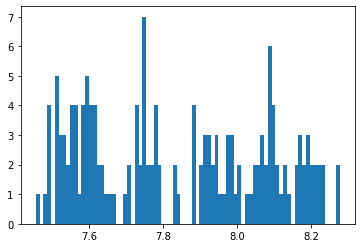

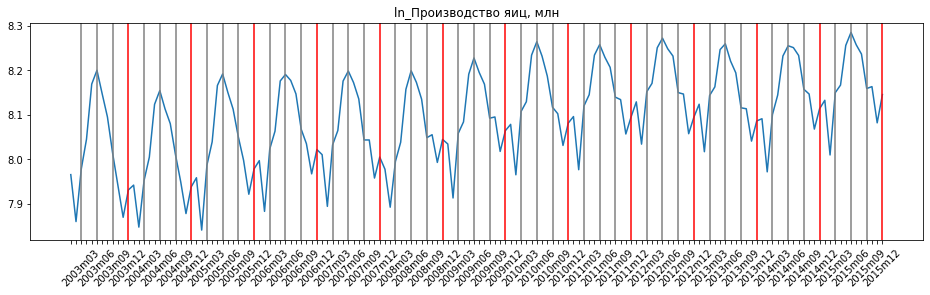

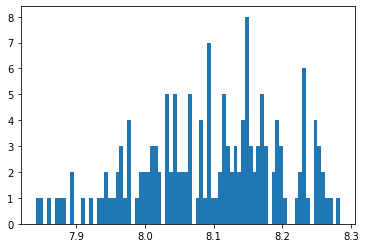

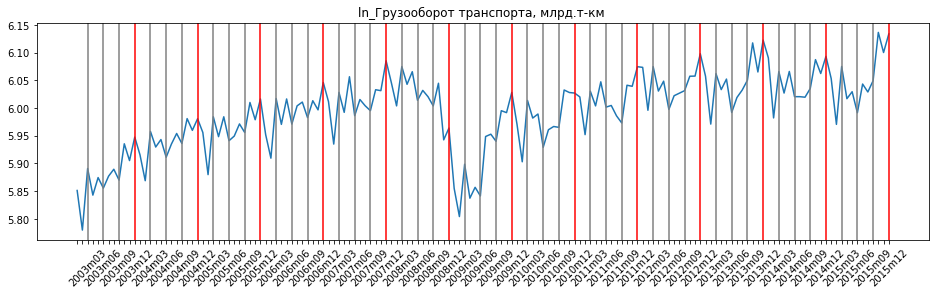

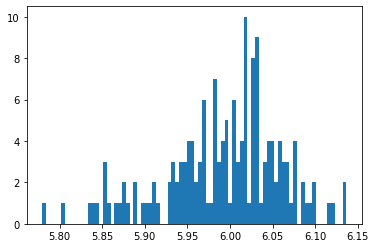

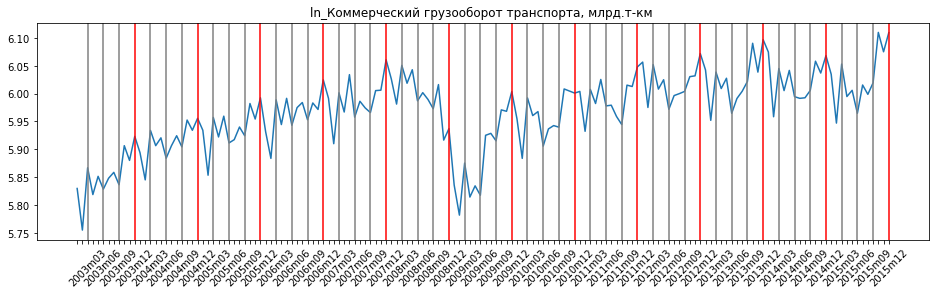

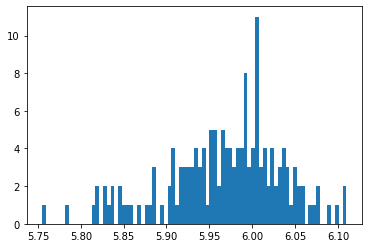

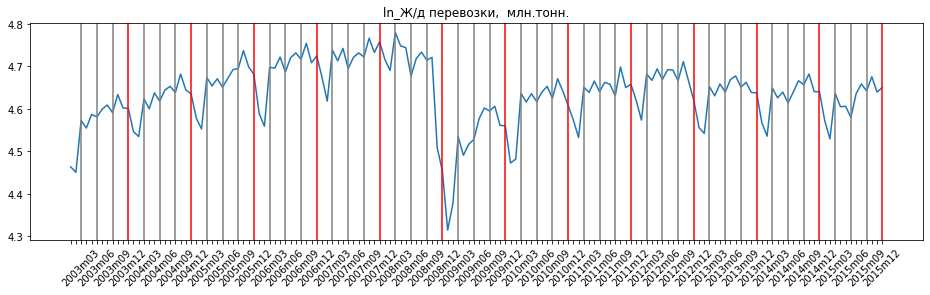

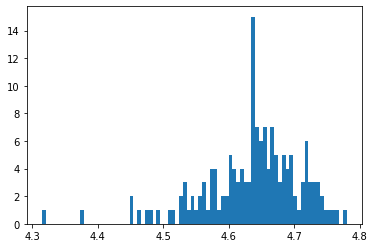

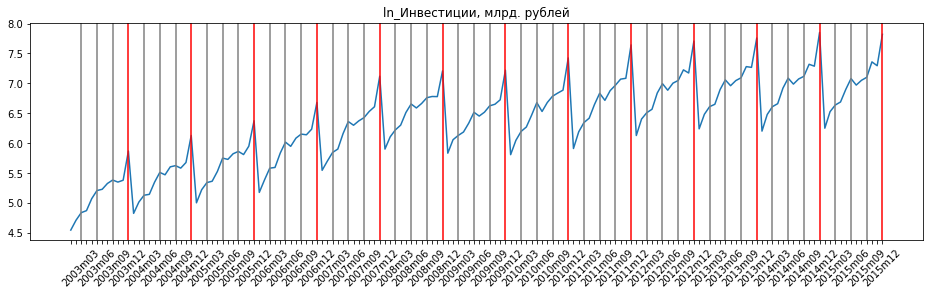

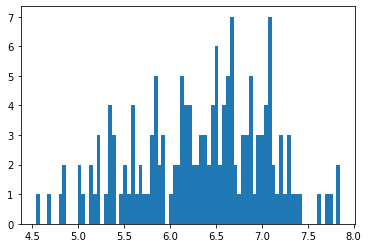

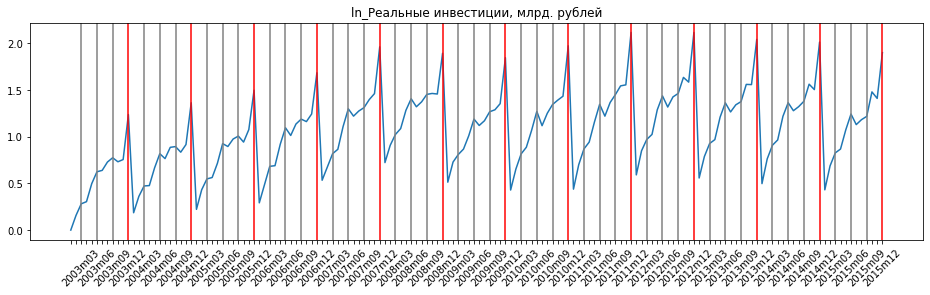

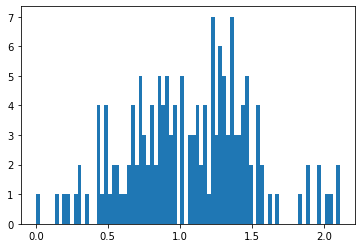

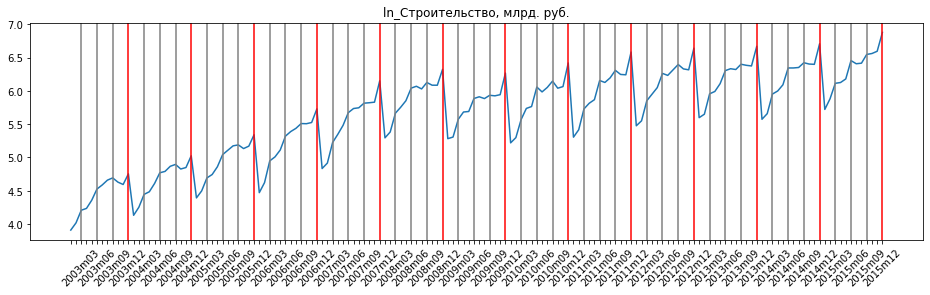

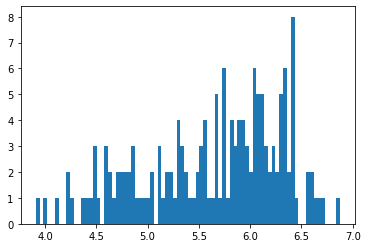

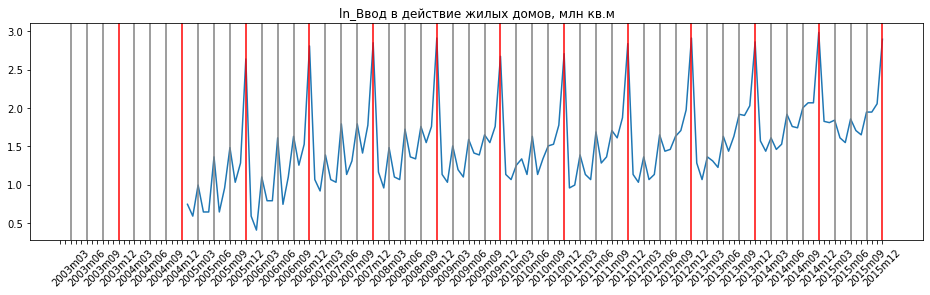

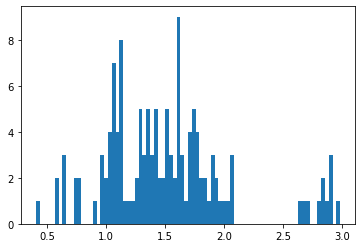

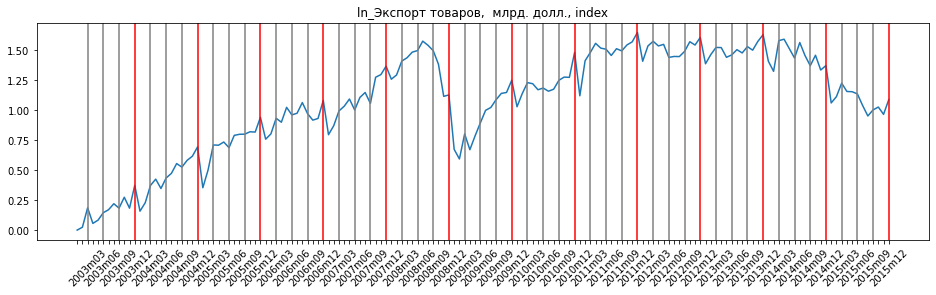

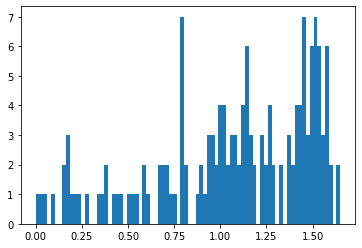

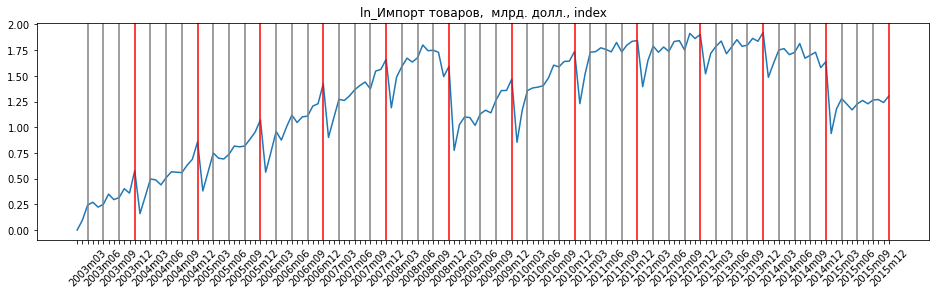

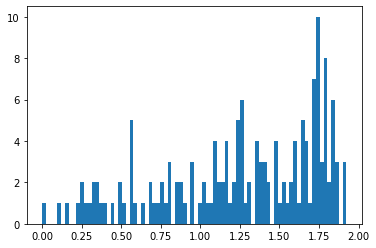

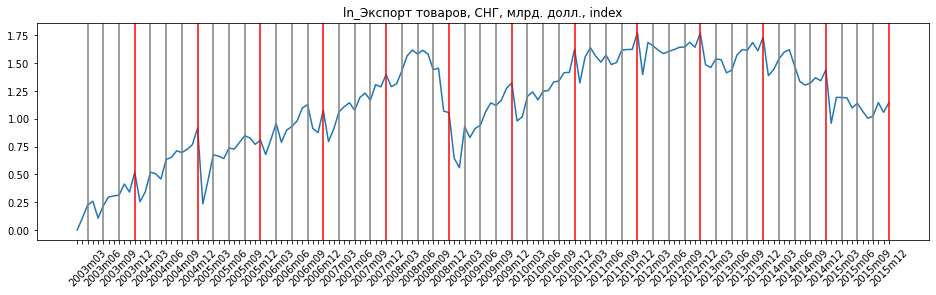

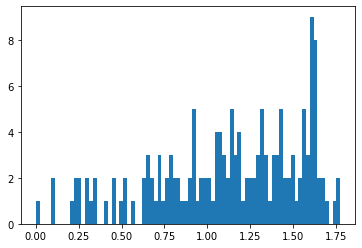

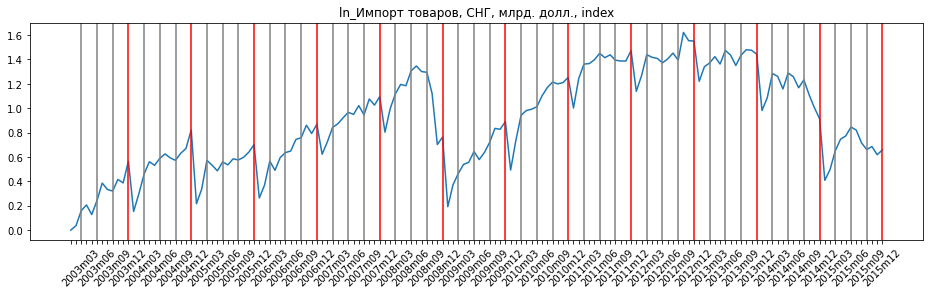

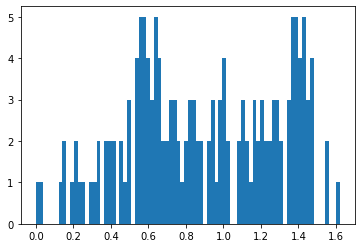

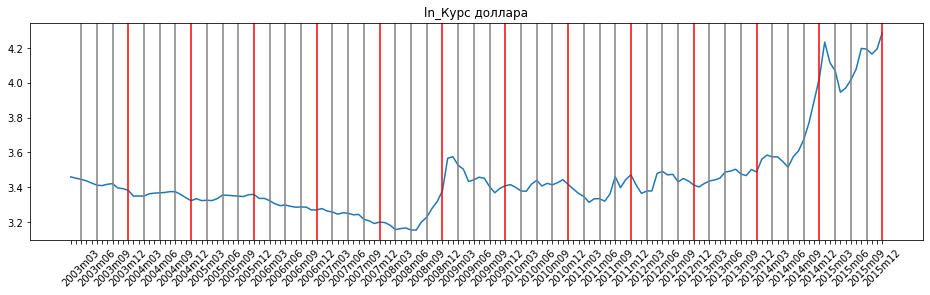

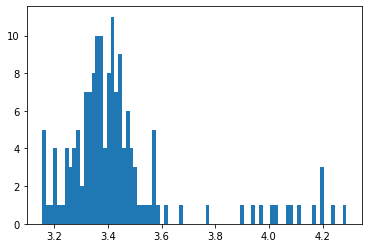

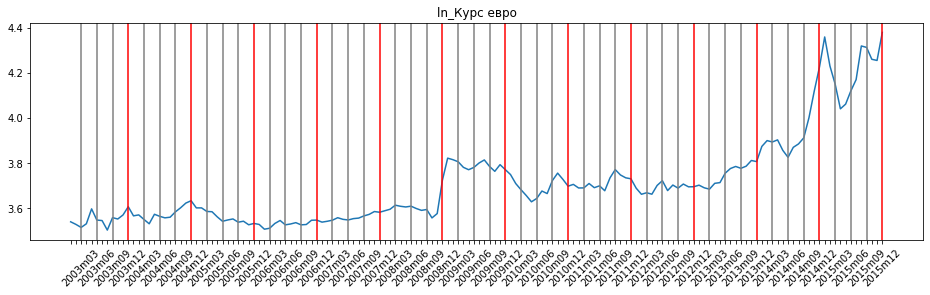

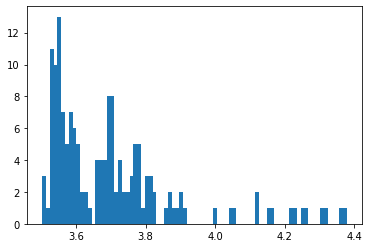

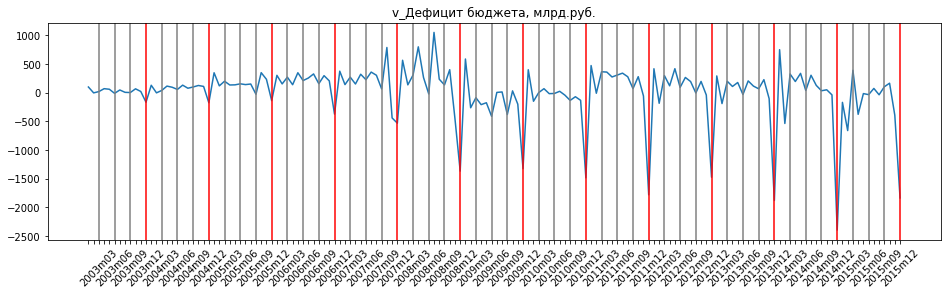

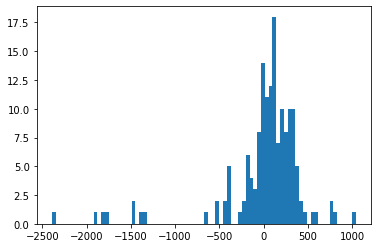

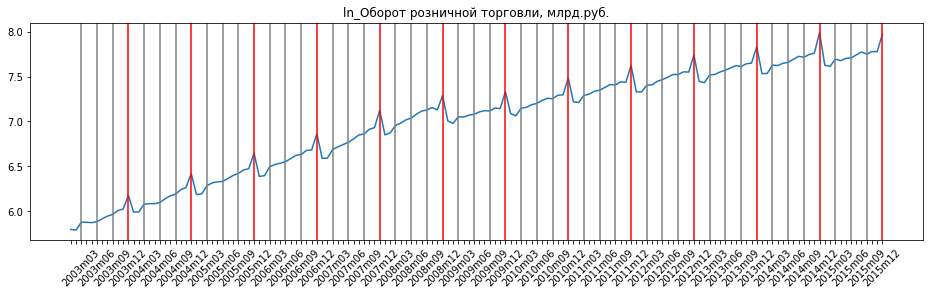

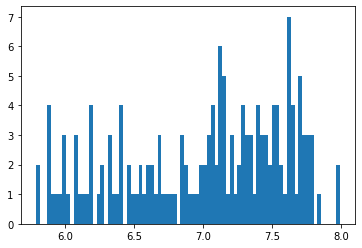

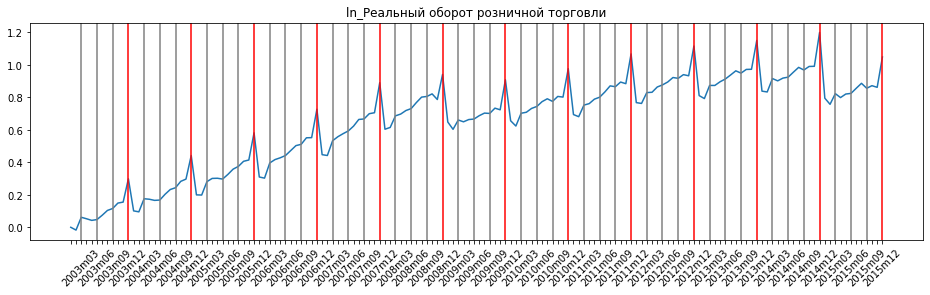

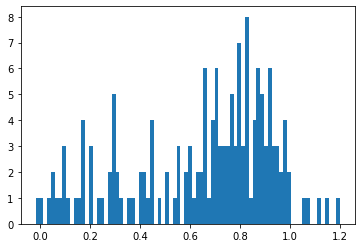

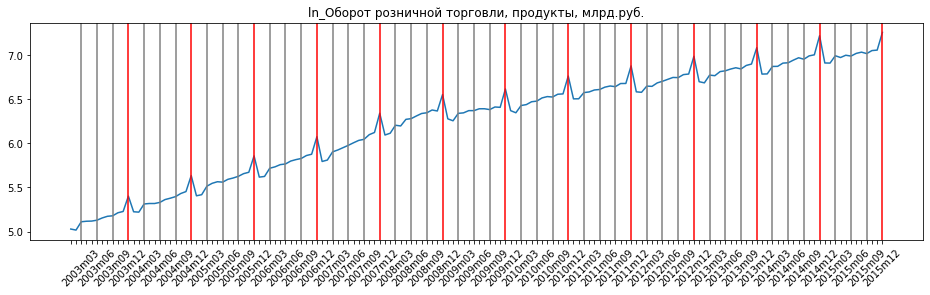

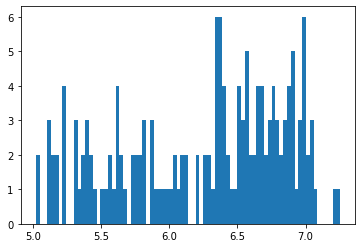

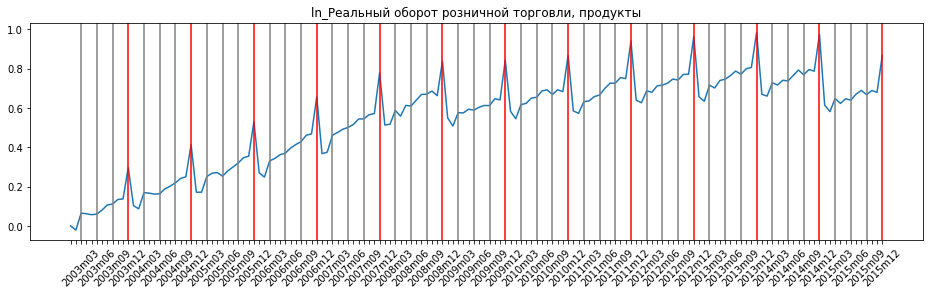

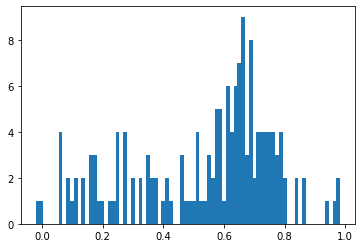

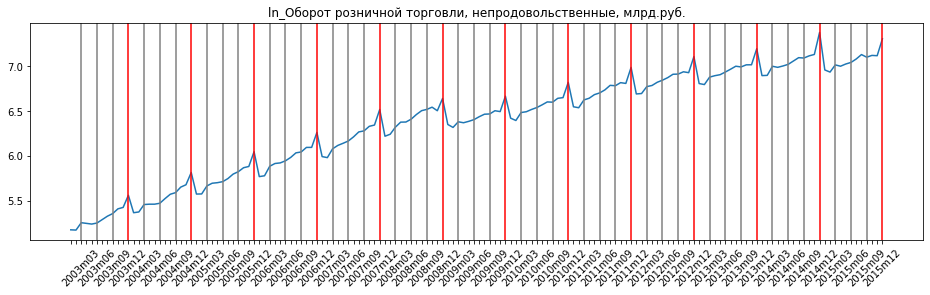

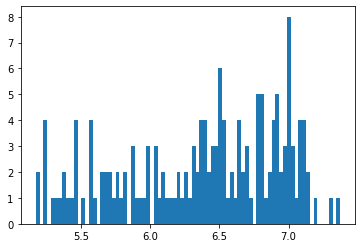

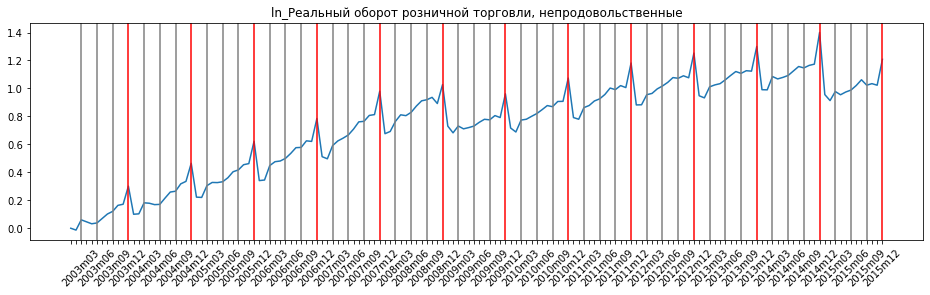

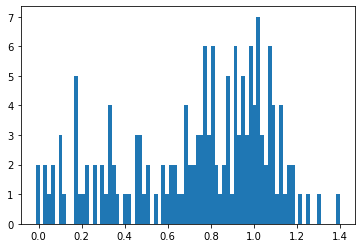

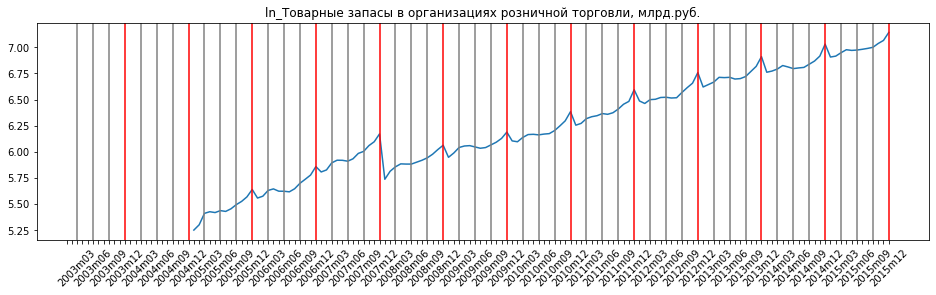

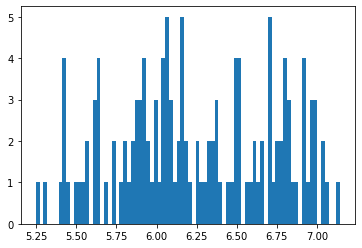

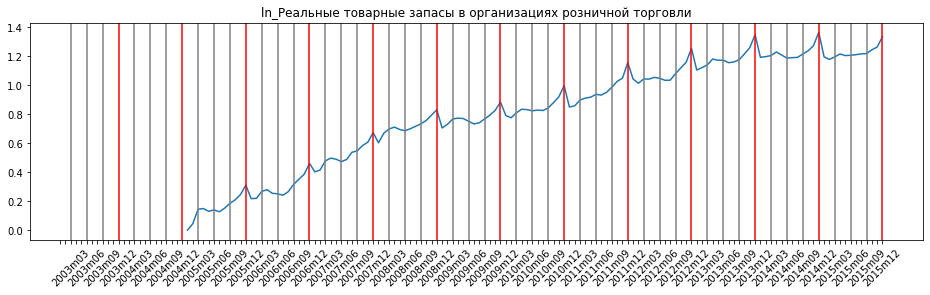

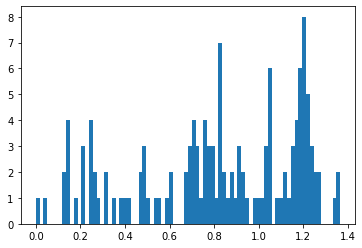

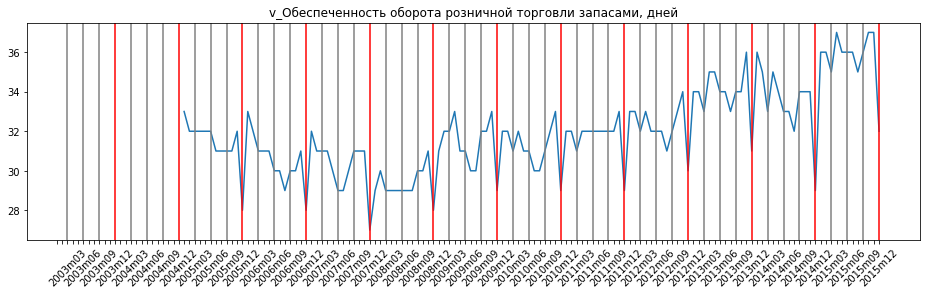

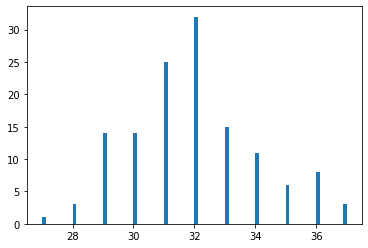

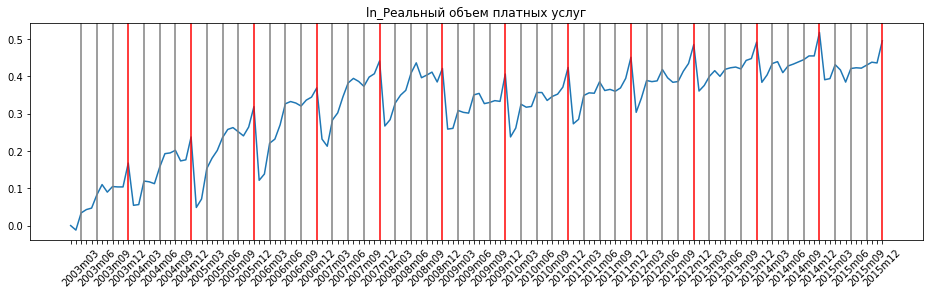

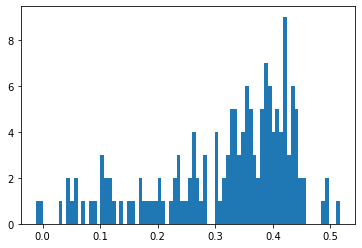

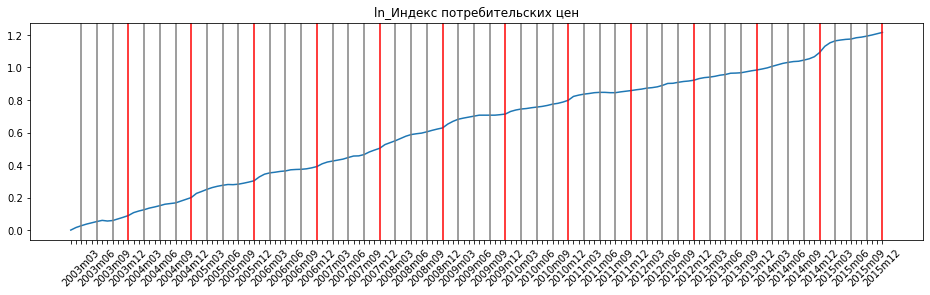

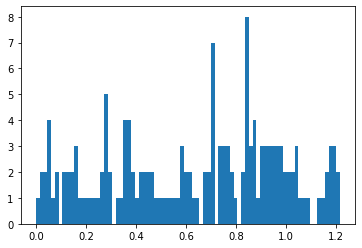

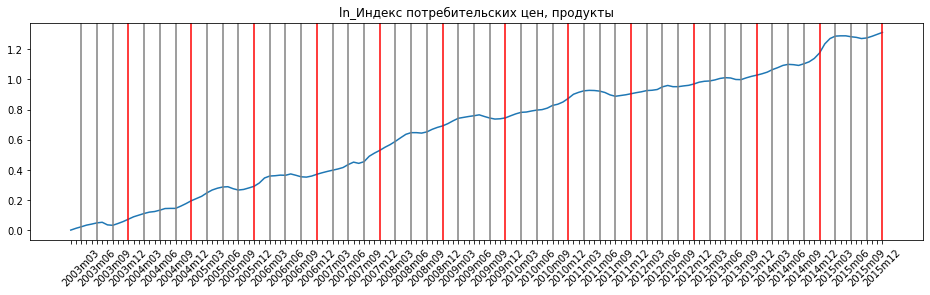

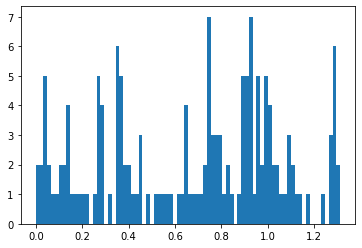

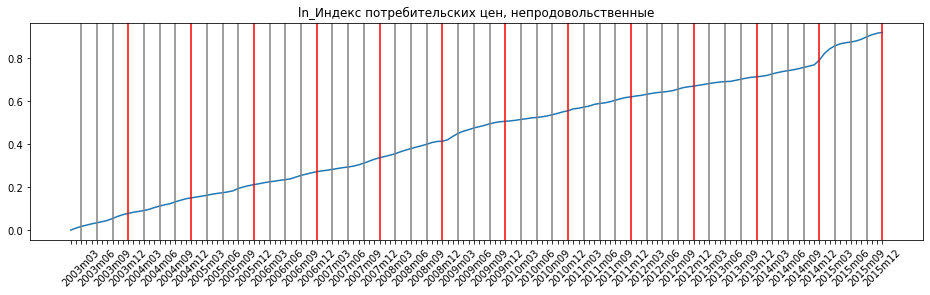

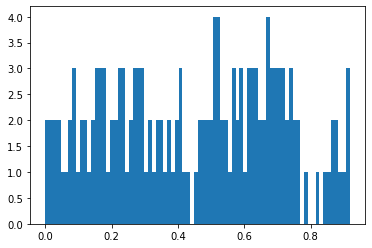

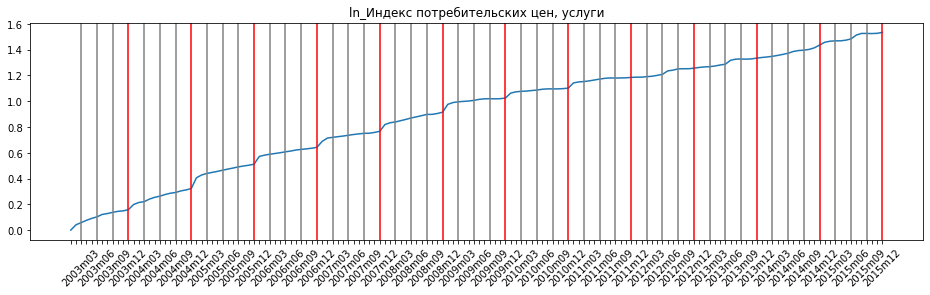

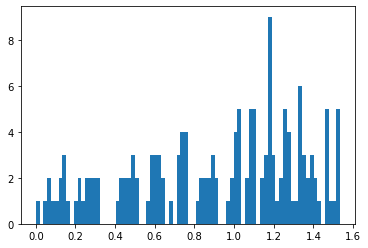

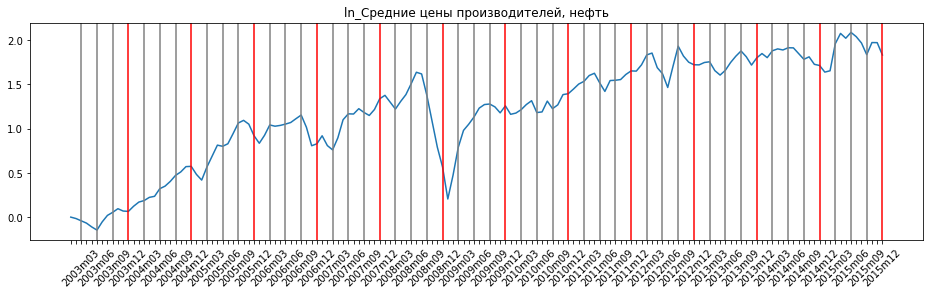

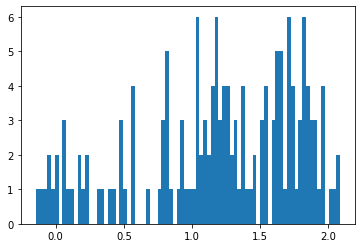

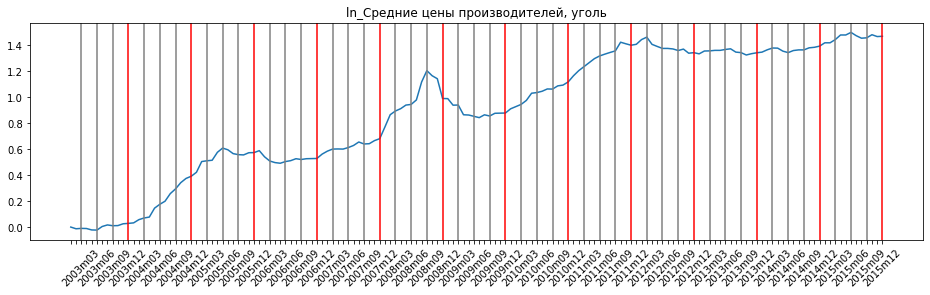

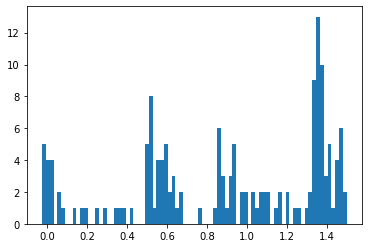

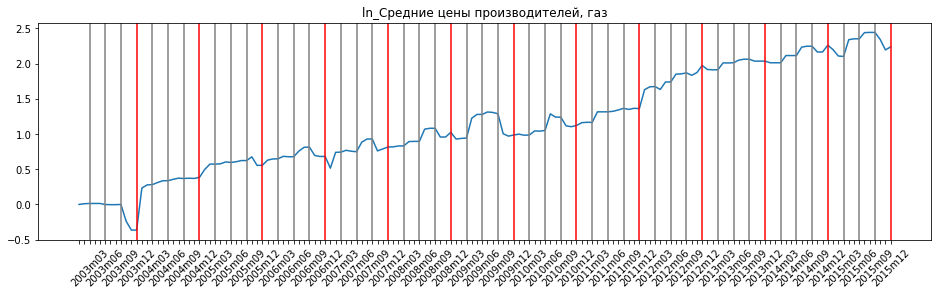

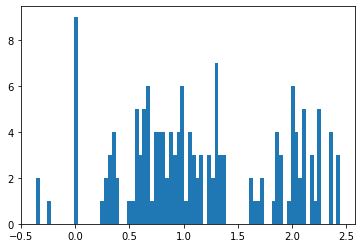

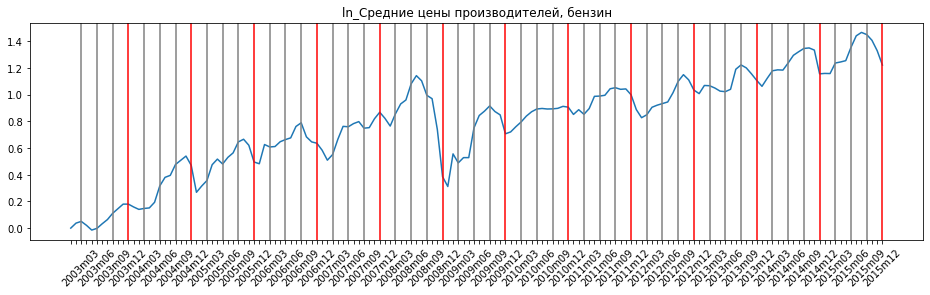

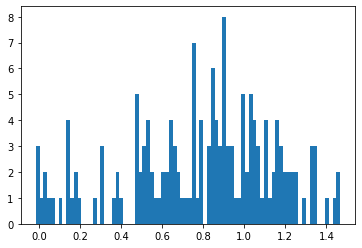

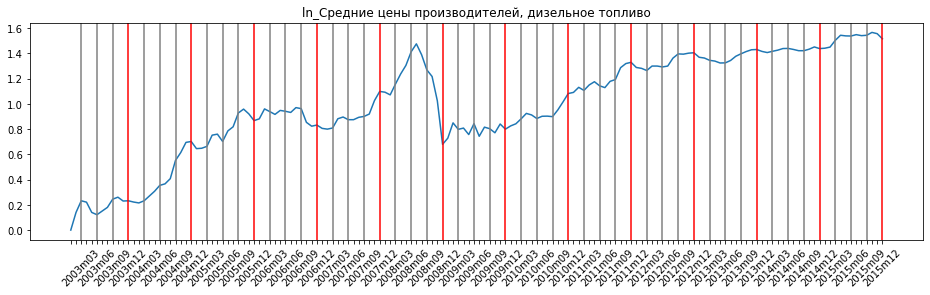

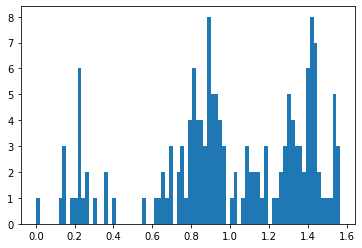

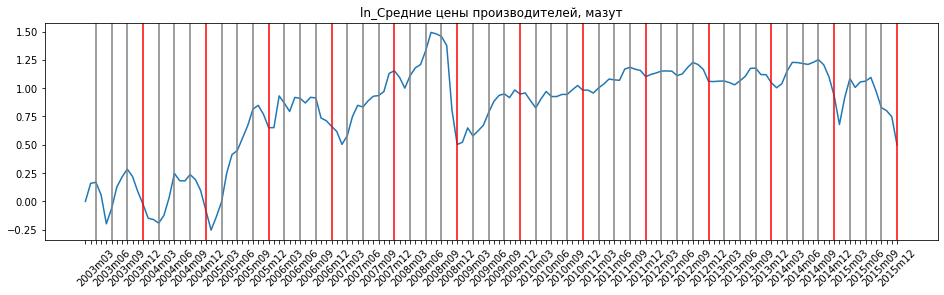

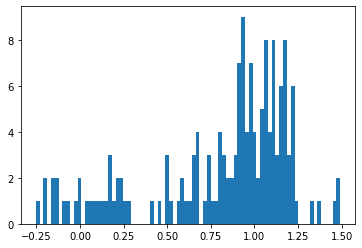

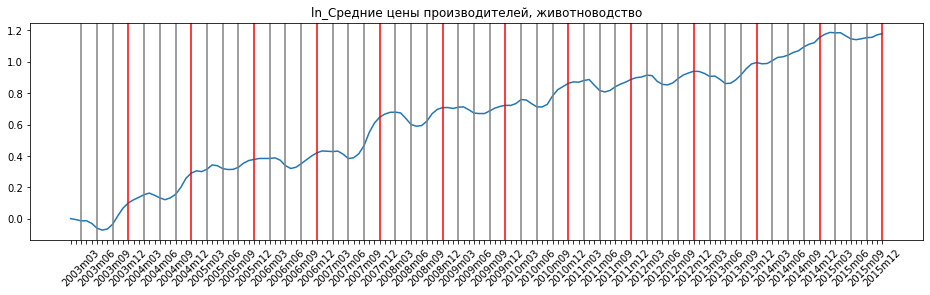

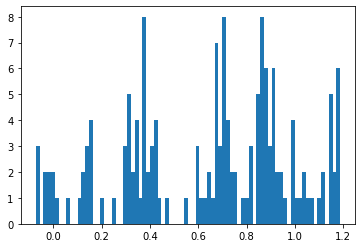

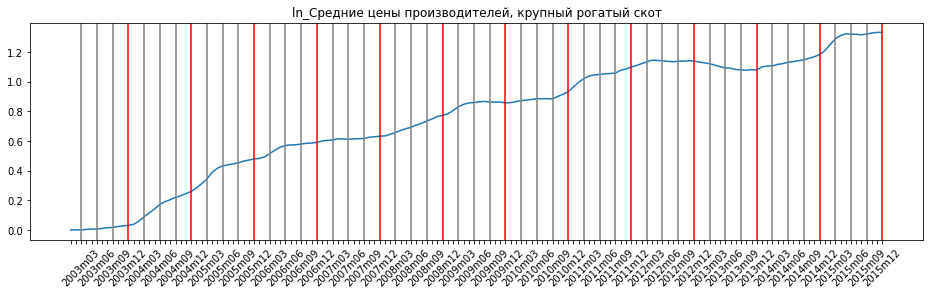

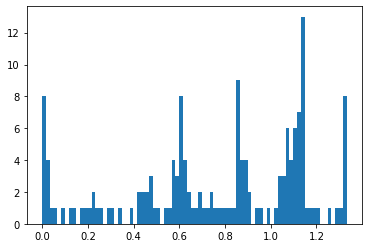

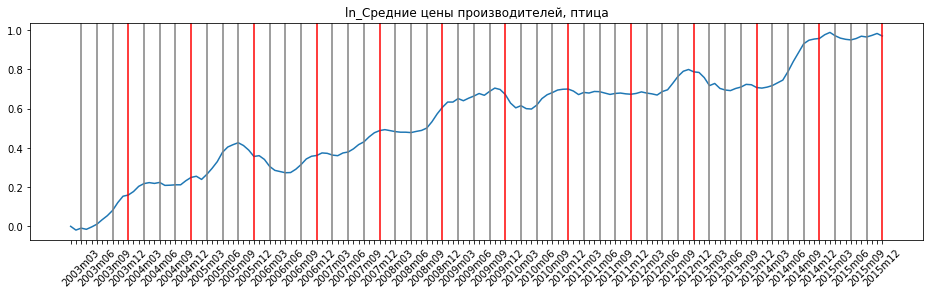

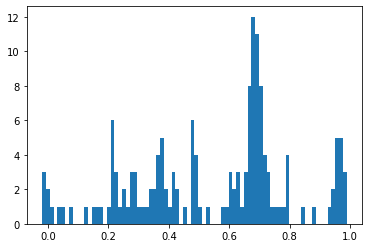

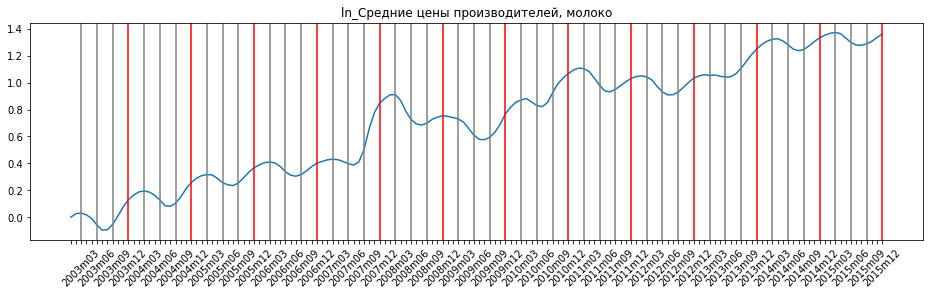

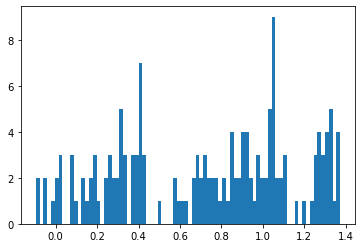

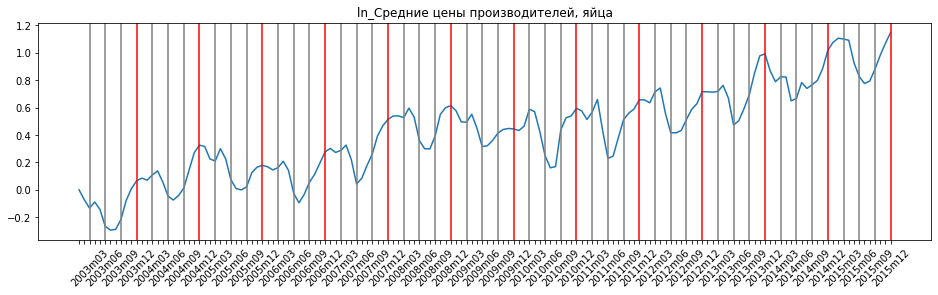

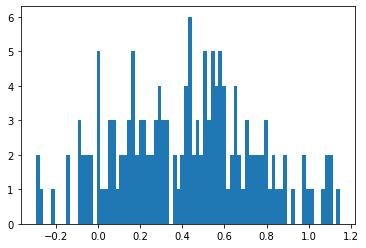

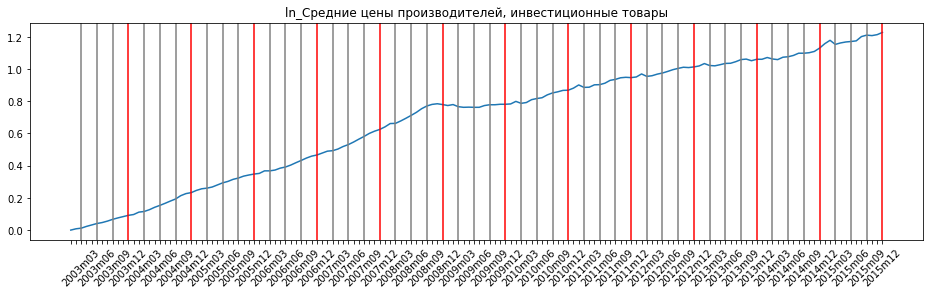

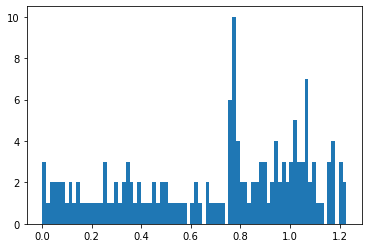

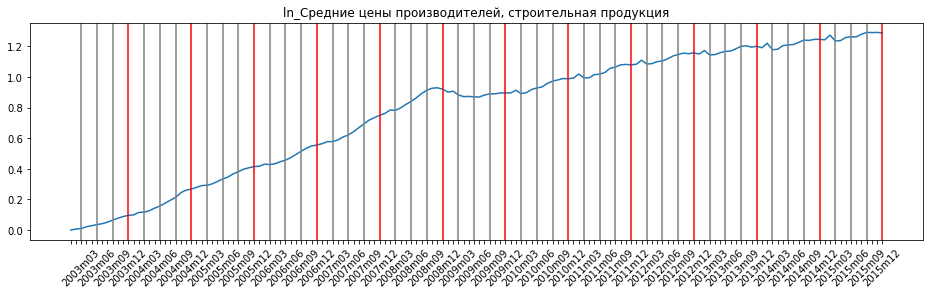

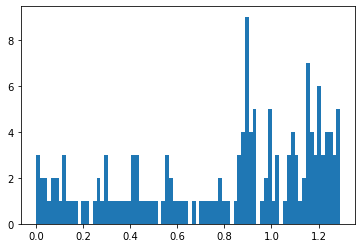

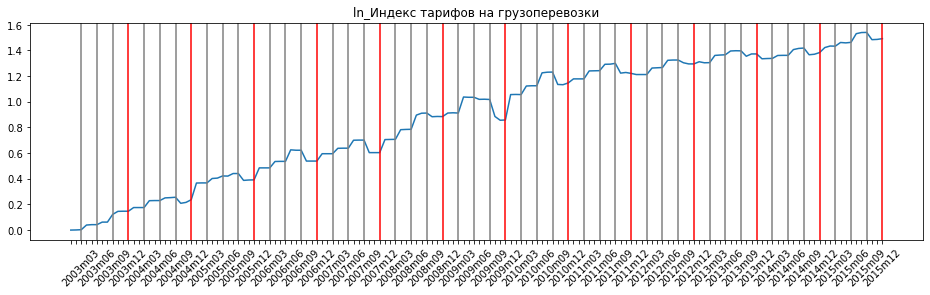

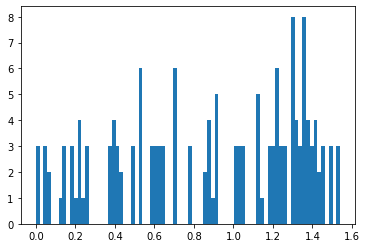

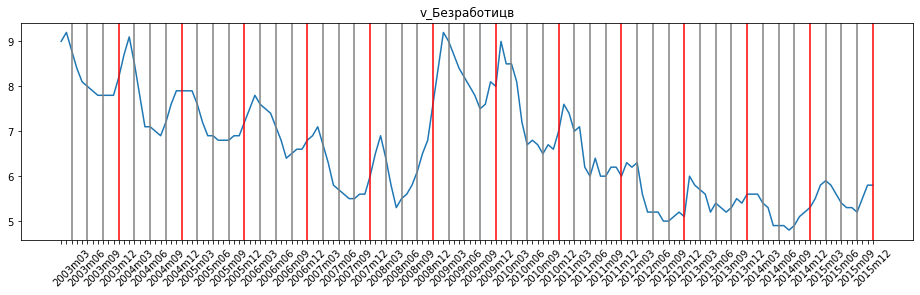

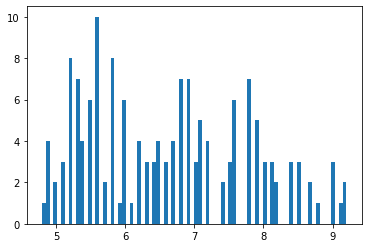

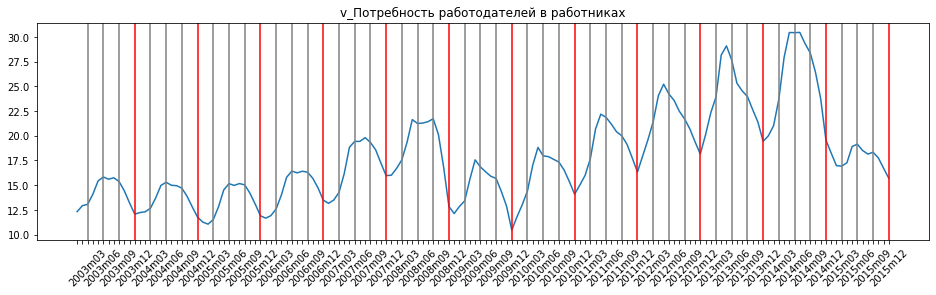

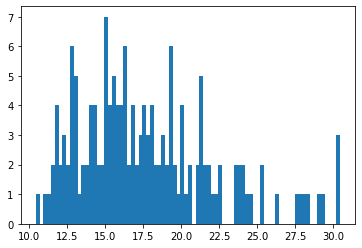

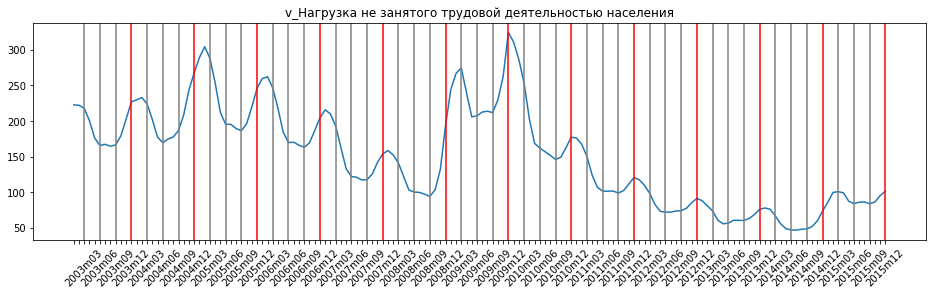

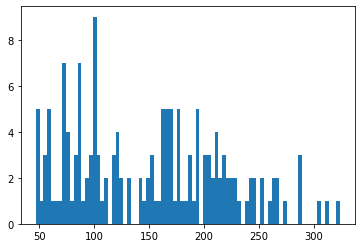

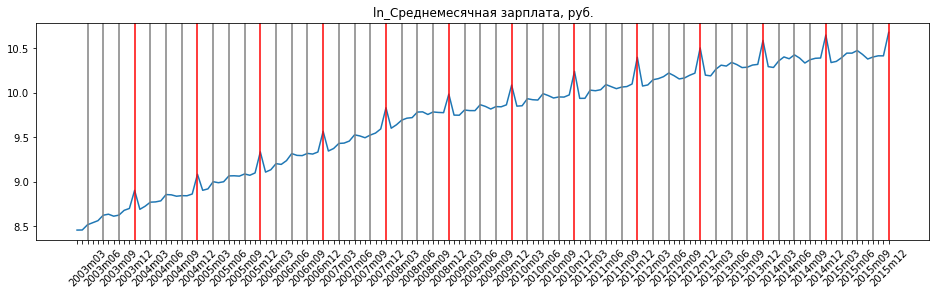

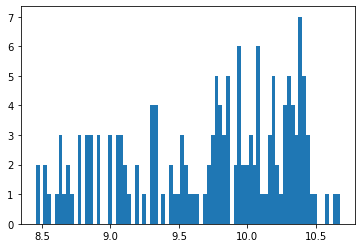

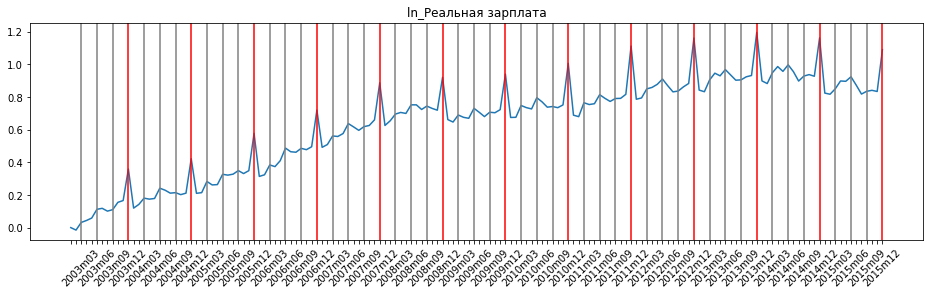

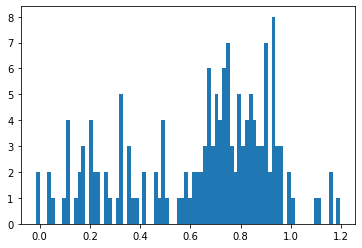

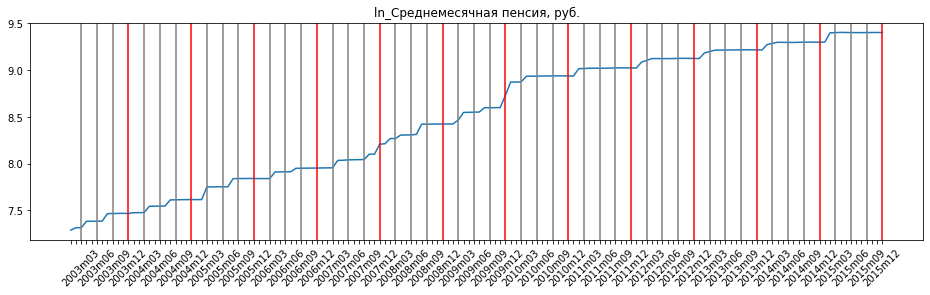

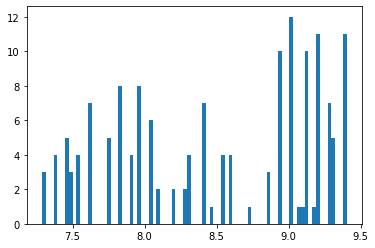

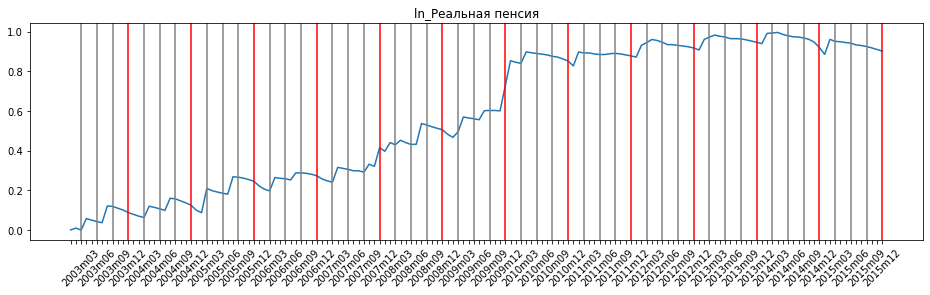

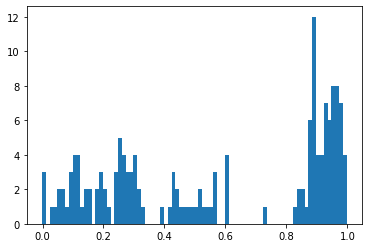

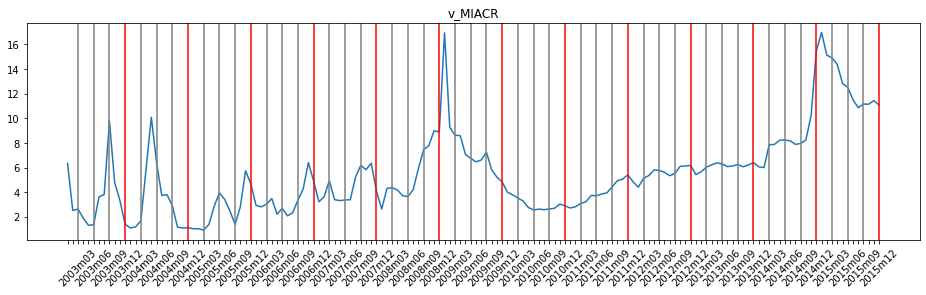

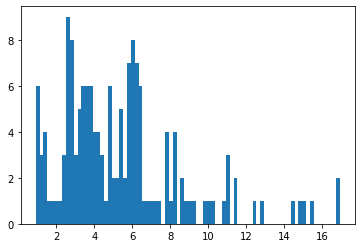

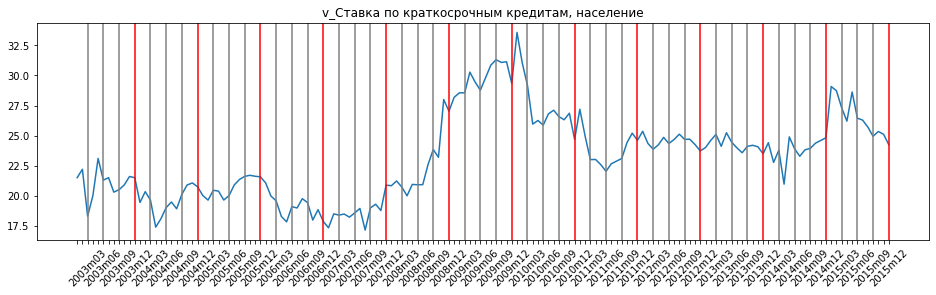

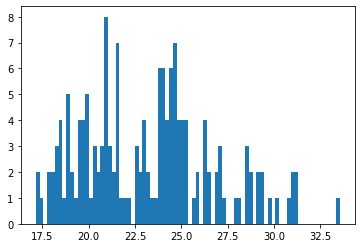

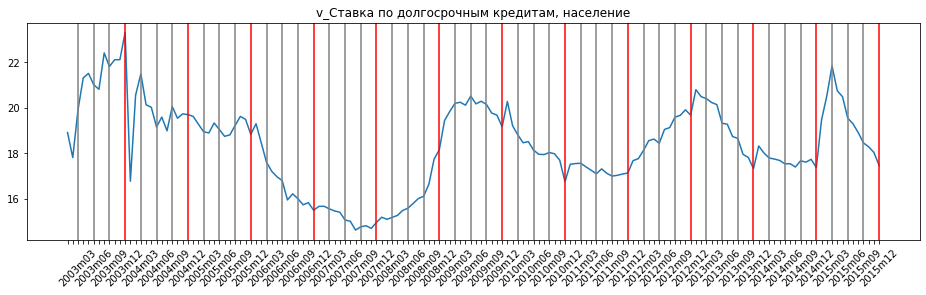

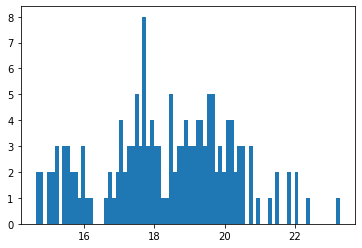

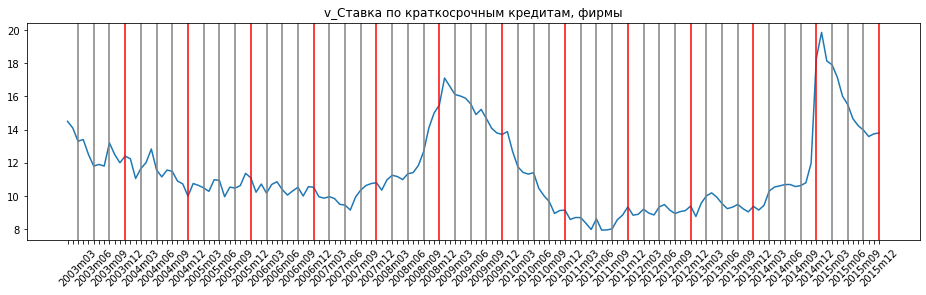

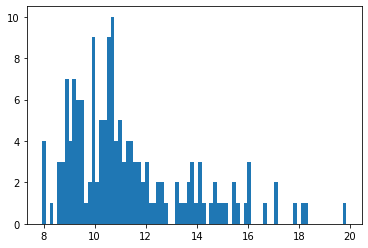

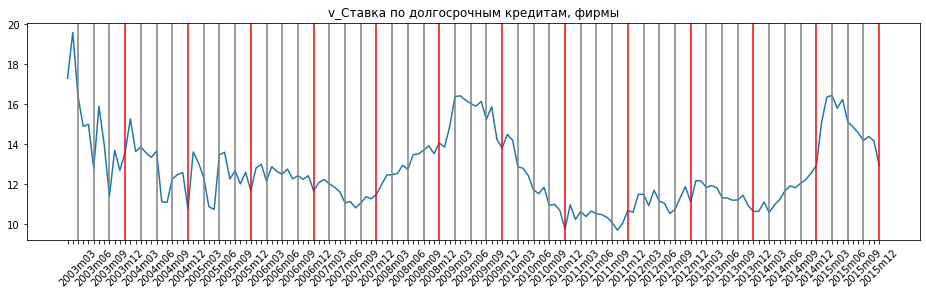

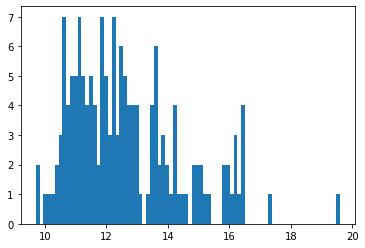

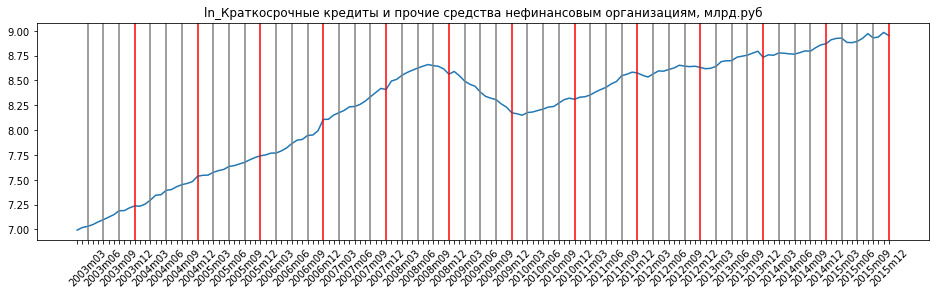

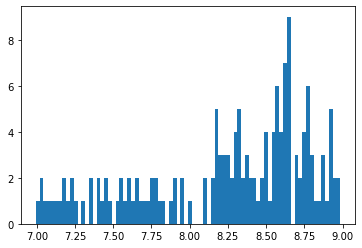

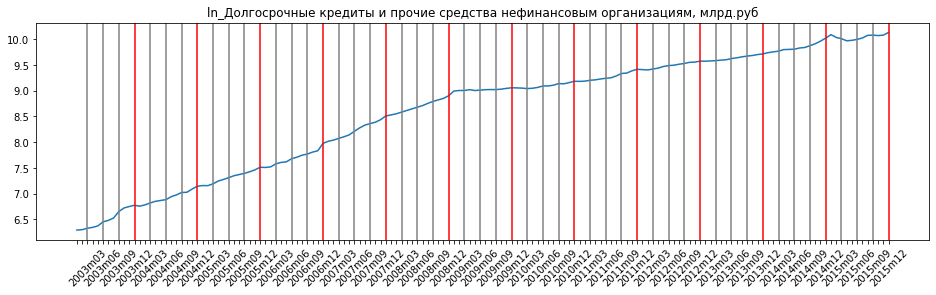

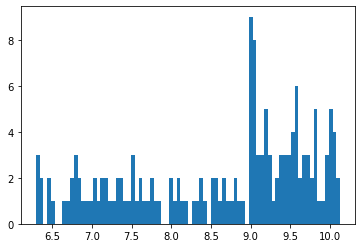

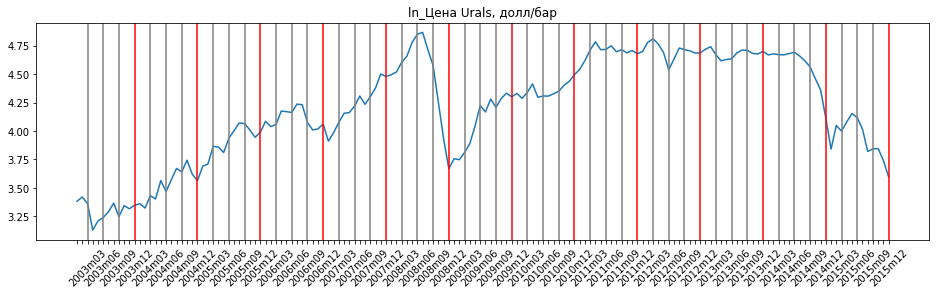

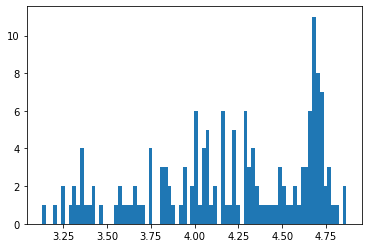

In [760]:
plot_every_col_m(train_m)

In [774]:
def plot_every_col_m_hist(df):
    ylines_x_grey = np.ravel([[f'{_y}m{_m:02d}' for _m in [3,6,9]] for _y in range(2003, 2016)])
    ylines_x_red = np.ravel([[f'{_y}m{_m:02d}' for _m in [12]] for _y in range(2003, 2016)])
    for _col in df.columns[:2]:
        to_plot = df.loc[:, _col]
        plt.figure(figsize=(16,4))
#         plt.title(_col)
        f, ax = plt.subplots(1,len(df.columns[:2]))
        for axis in np.ravel(ax):
            axis.hist(to_plot, bins=80)
#         xlabels = [val if (i+1)%3==0 else '' for i,val in enumerate(df.index) ]
#         plt.xticks(ticks=range(0,len(xlabels)), 
#                    labels=xlabels,
#                    rotation=45)
#         plt.plot(to_plot)
#         [plt.axvline(x=_yline_x, c='grey') for _yline_x in ylines_x_grey]
#         [plt.axvline(x=_yline_x, c='red') for _yline_x in ylines_x_red]
#         plt.show()
    plt.show()


In [147]:
def plot_every_col_q(df):
    ylines_x_grey = np.ravel([[f'{_y}m{_m:02d}' for _m in [3,6,9]] for _y in range(2003, 2016)])
    ylines_x_red = np.ravel([[f'{_y}m{_m:02d}' for _m in [12]] for _y in range(2003, 2016)])
    for _col in df.columns:
        to_plot = df.loc[:, _col]
        plt.figure(figsize=(16,4))
        plt.title(_col)
#         xlabels = [val if (i+1)%3==0 else '' for i,val in enumerate(df.index) ]
        plt.xticks(
#             ticks=range(0,len(xlabels)), 
#             labels=xlabels,
            rotation=45
        )
        plt.plot(to_plot)
        [plt.axvline(x=_yline_x, c='grey') for _yline_x in ylines_x_grey]
        [plt.axvline(x=_yline_x, c='red') for _yline_x in ylines_x_red]
        plt.show()


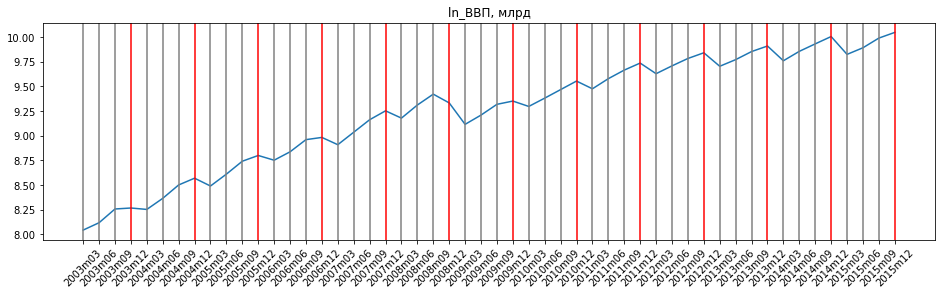

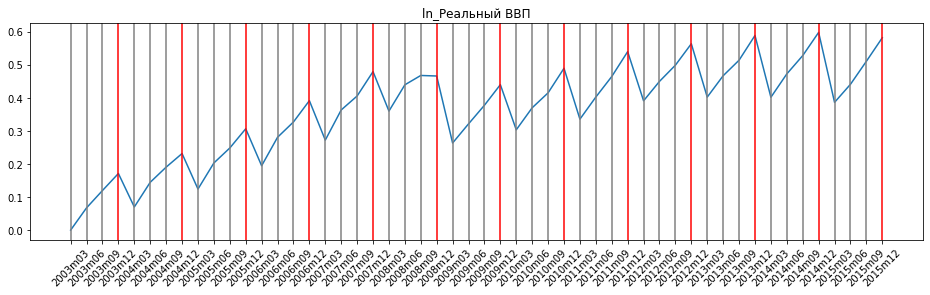

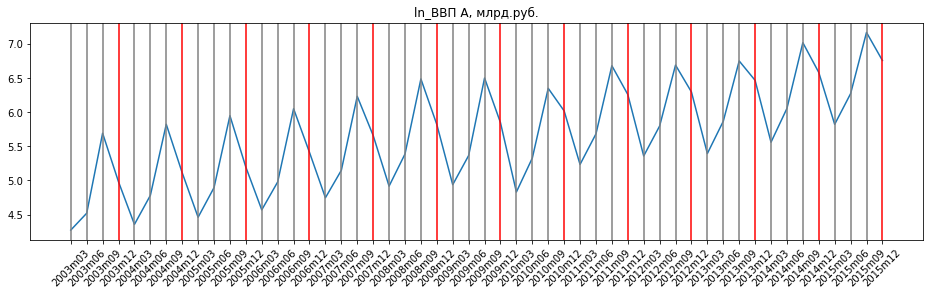

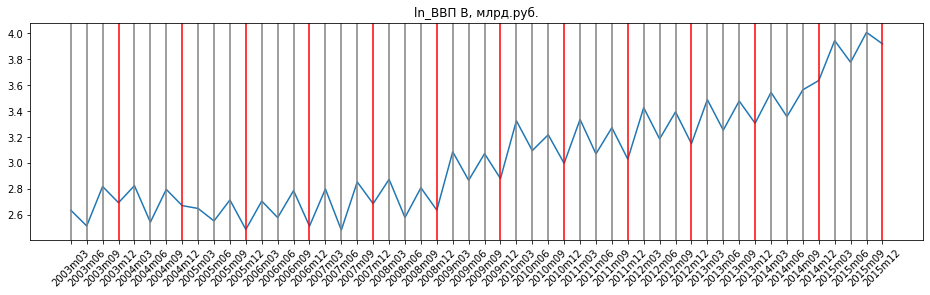

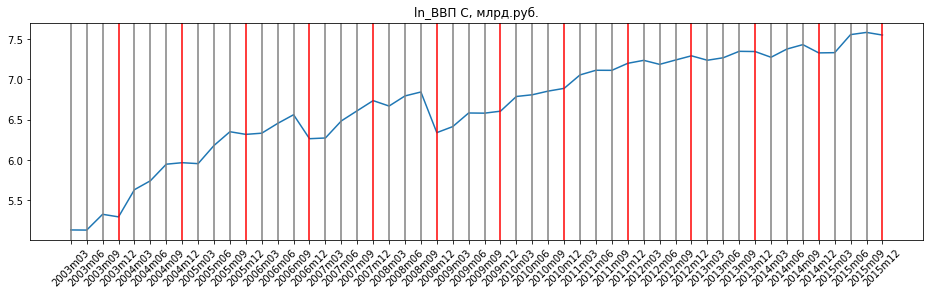

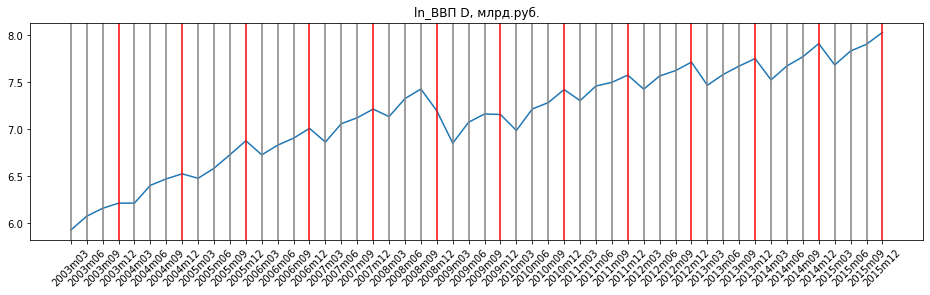

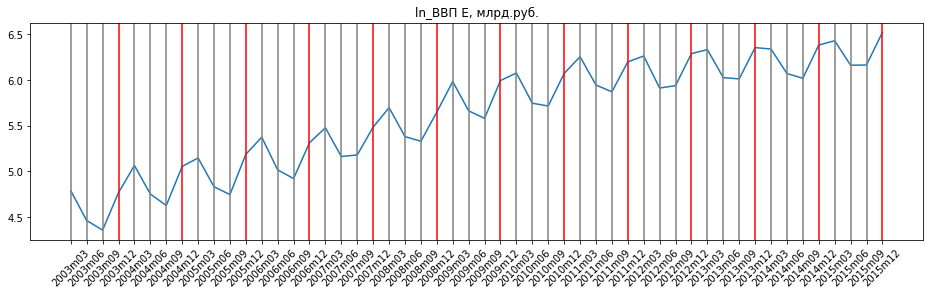

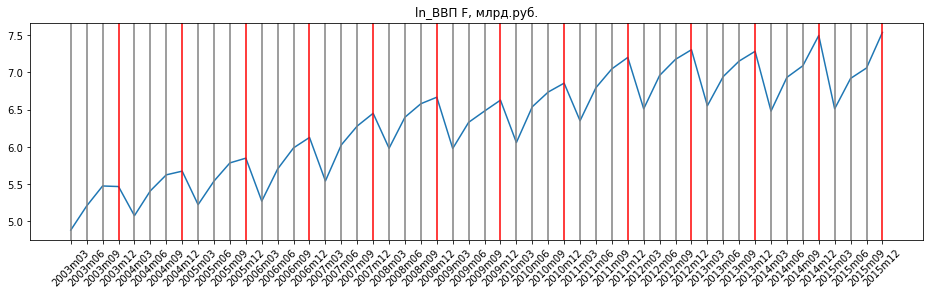

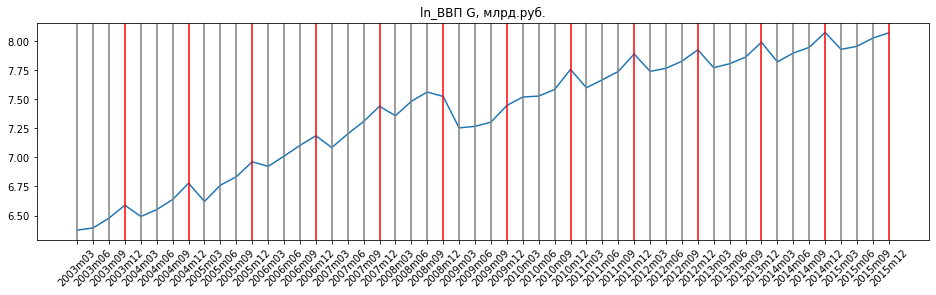

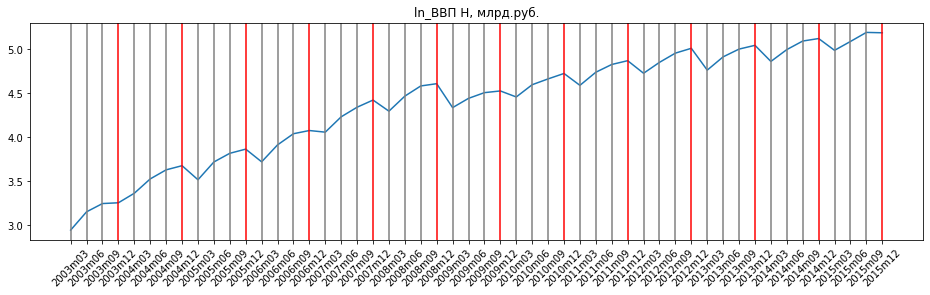

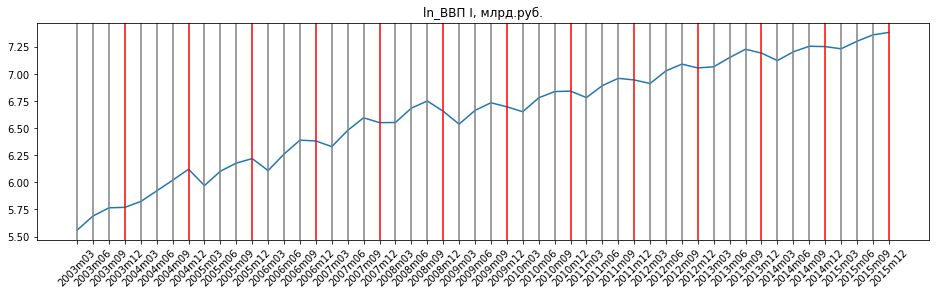

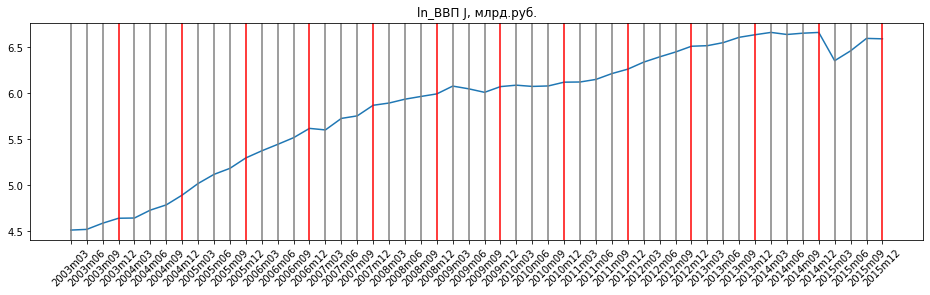

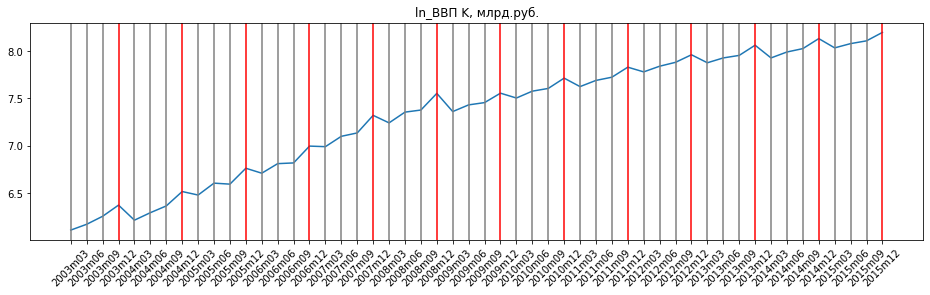

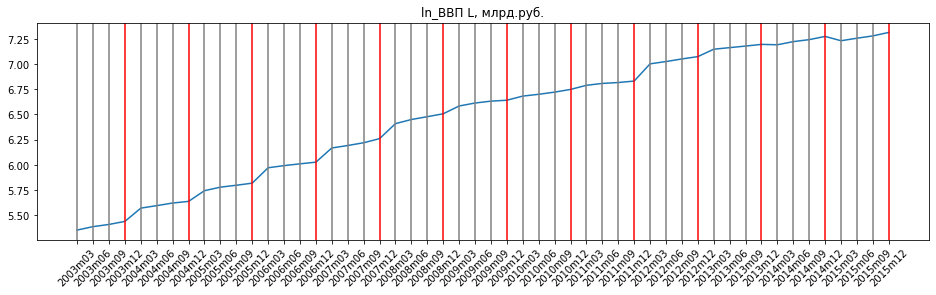

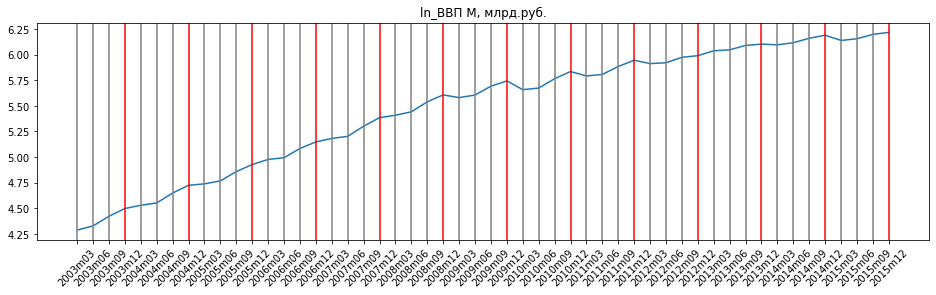

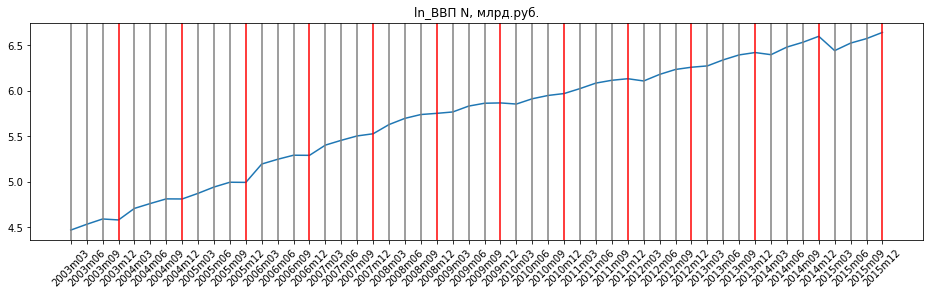

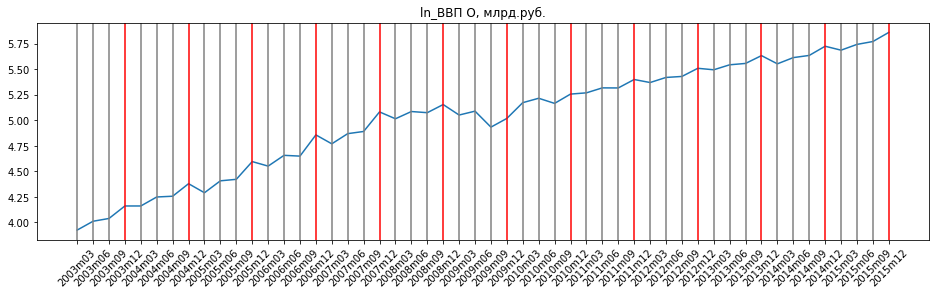

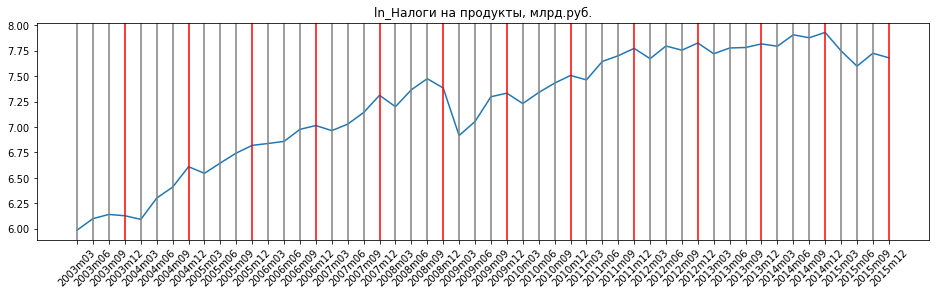

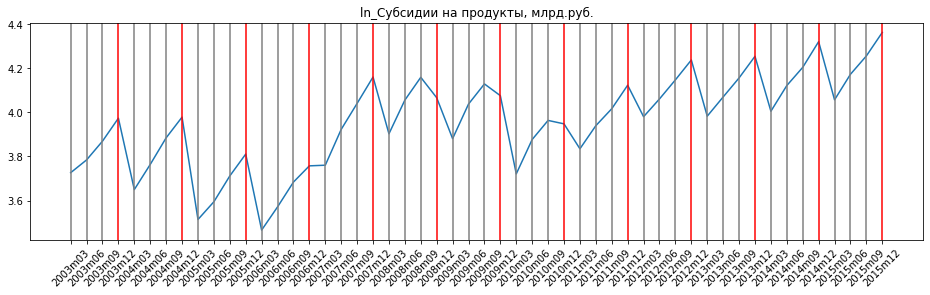

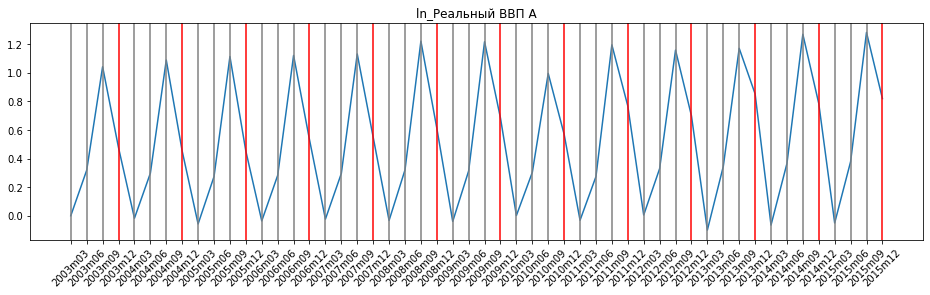

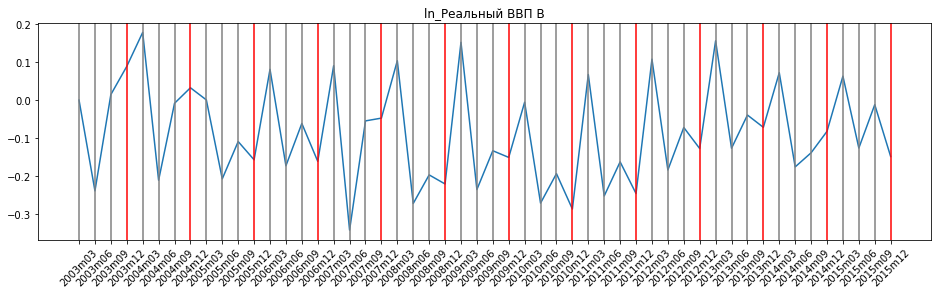

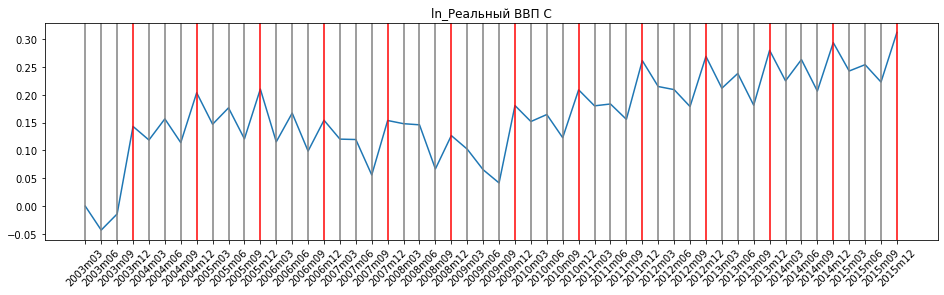

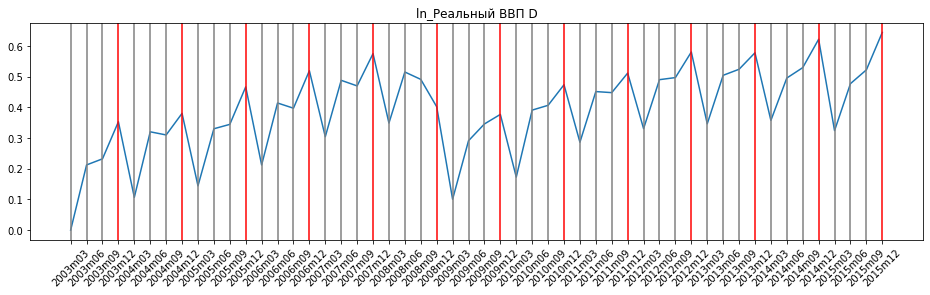

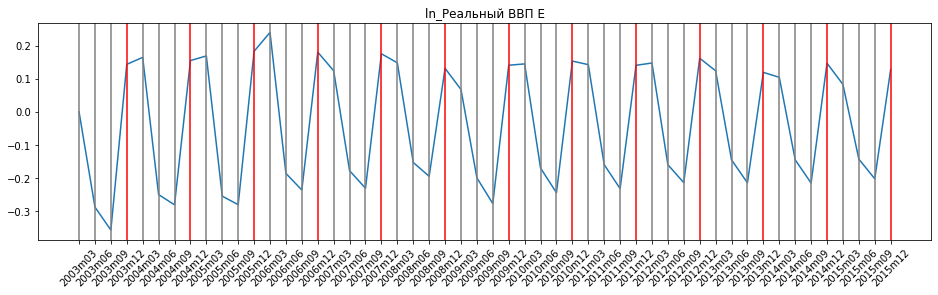

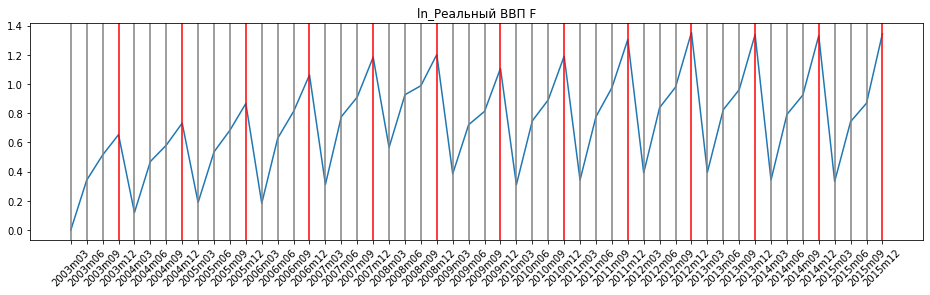

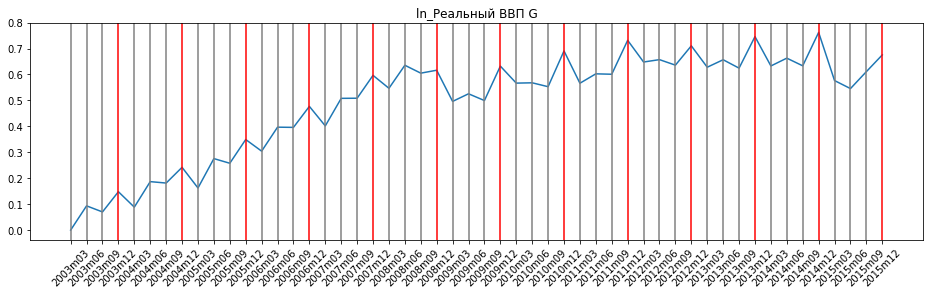

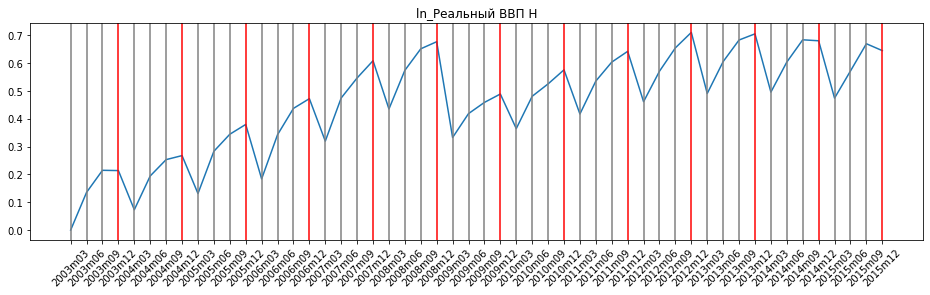

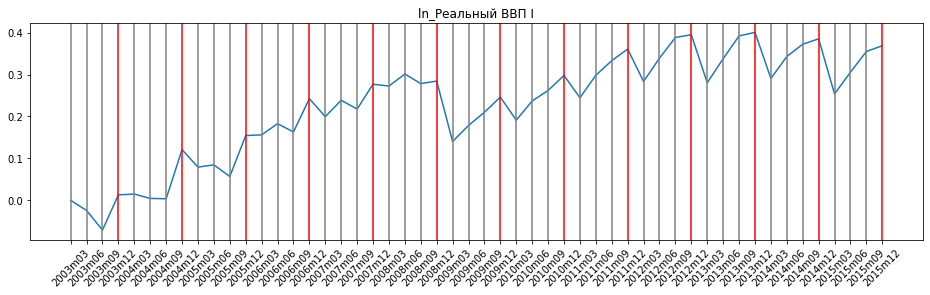

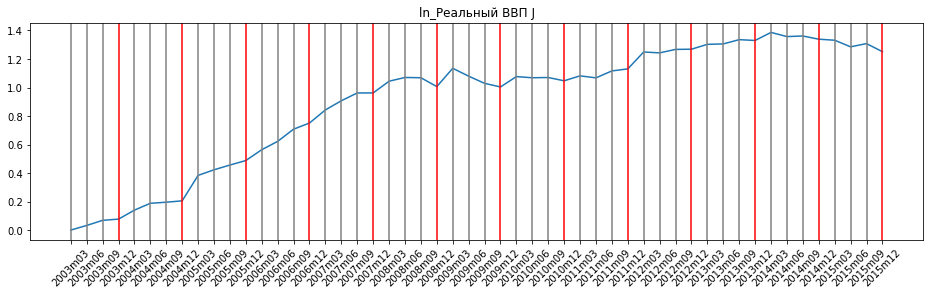

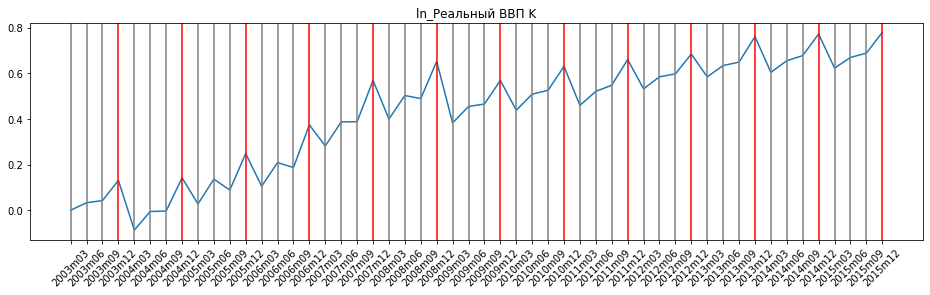

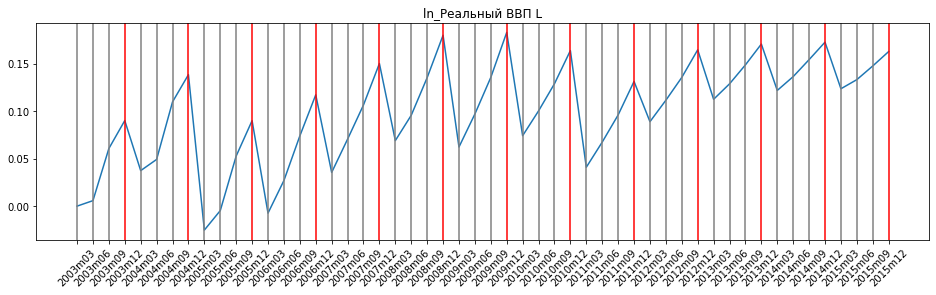

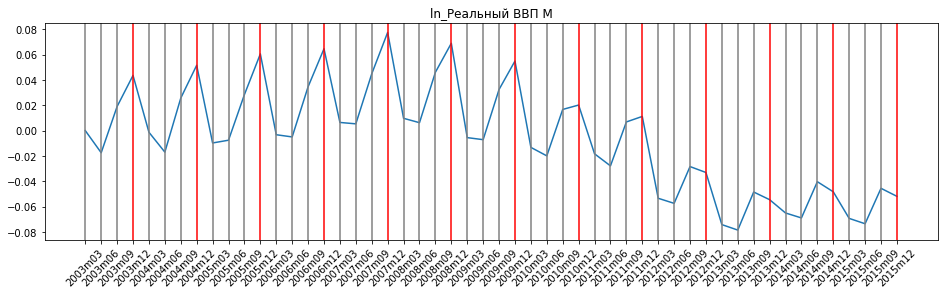

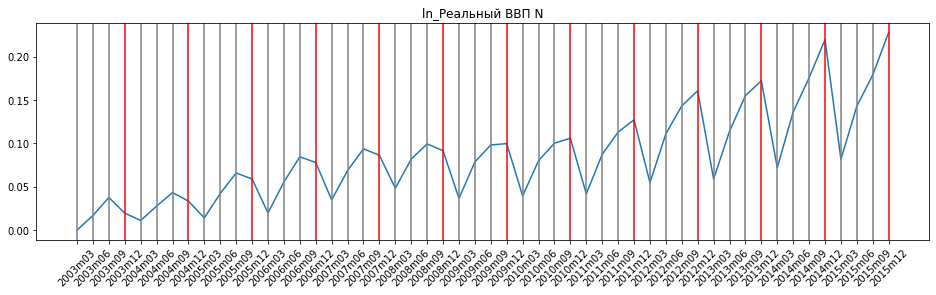

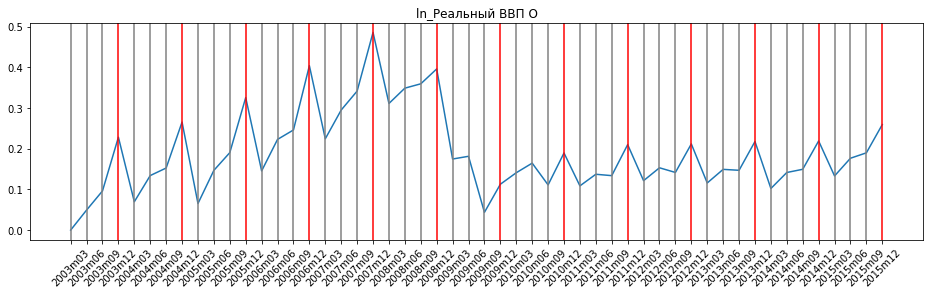

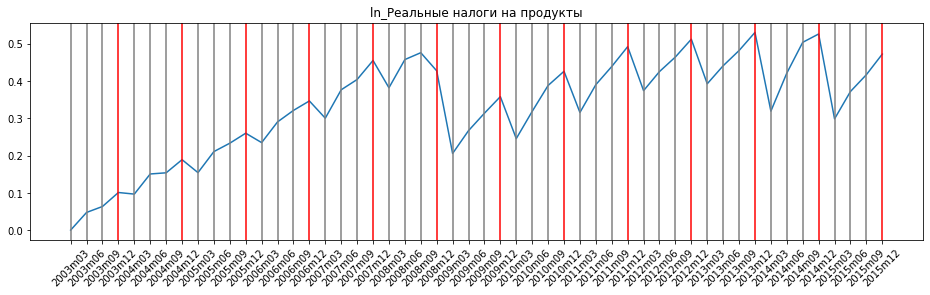

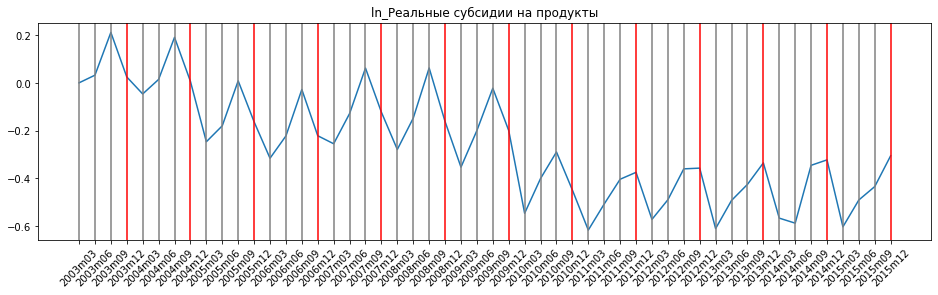

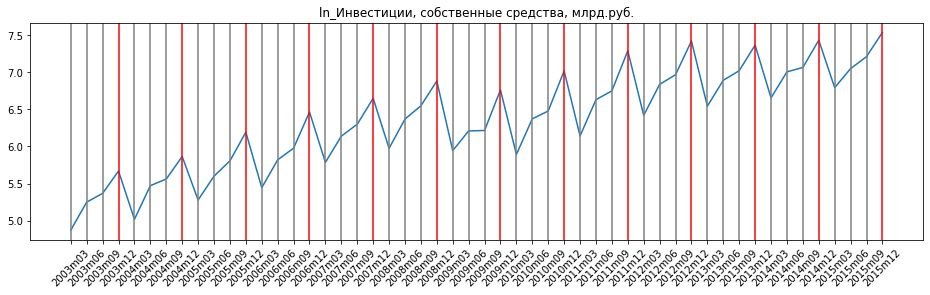

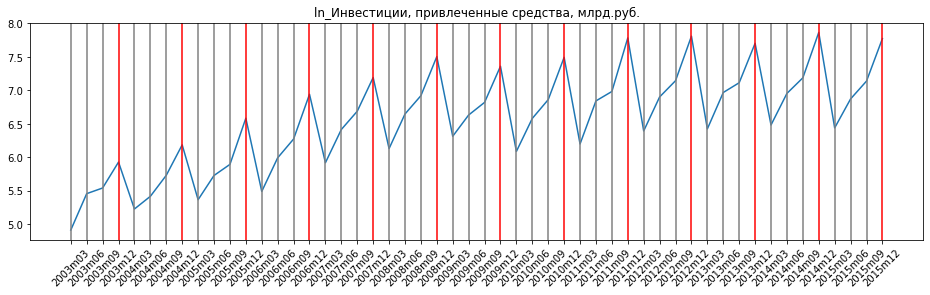

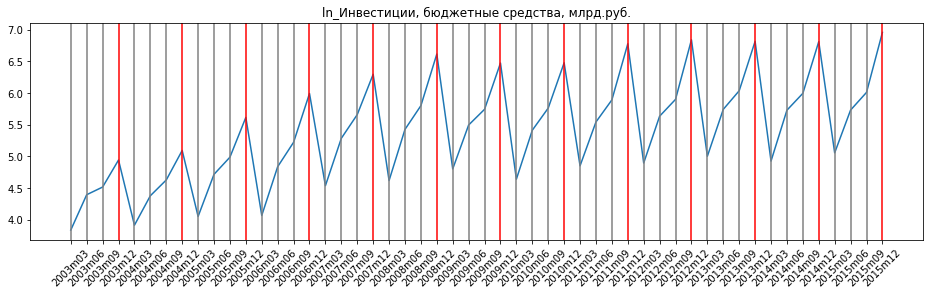

In [149]:
plot_every_col(train_q)

# Строим тест

In [779]:
test = pd.ExcelFile('data/Test_example2.xlsx')
dfd = {}
for _sheet_name in test.sheet_names:
    print(_sheet_name)
    dfd[_sheet_name] = test.parse(_sheet_name, index_col=0, na_values='Forecast').astype(float)
    display(dfd[_sheet_name])    

Monthly


Var1   Var2      Var3      Var4
01m01  0.000000  6.331  3.383413  0.000000
01m02  0.015873  2.514  3.420624 -0.017146
01m03  0.026813  2.625  3.363693  0.061665
01m04  0.036764  1.888  3.130242  0.052624
01m05  0.044732  1.308  3.210488  0.042574
...         ...    ...       ...       ...
10m08       NaN    NaN  4.728274       NaN
10m09       NaN    NaN  4.714565       NaN
10m10       NaN    NaN  4.703895       NaN
10m11       NaN    NaN  4.684857       NaN
10m12       NaN    NaN  4.685187       NaN

[120 rows x 4 columns]

Quarterly


Var1
01m03  0.000000
01m06  0.067384
01m09  0.119733
01m12  0.171204
02m03  0.069902
02m06  0.144623
02m09  0.190418
02m12  0.231542
03m03  0.124161
03m06  0.203014
03m09  0.248313
03m12  0.306468
04m03  0.194607
04m06  0.280739
04m09  0.327038
04m12  0.391548
05m03  0.272211
05m06  0.363405
05m09  0.405602
05m12  0.479425
06m03  0.359995
06m06  0.439453
06m09  0.467745
06m12  0.466118
07m03  0.263462
07m06  0.321217
07m09  0.377615
07m12  0.439903
08m03  0.303360
08m06  0.370006
08m09  0.415163
08m12  0.489449
09m03  0.335573
09m06  0.402415
09m09  0.464539
09m12  0.539761
10m03       NaN
10m06       NaN
10m09       NaN
10m12       NaN

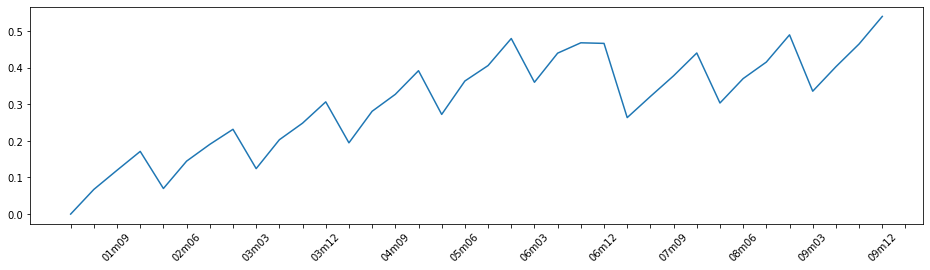

In [781]:
plt.figure(figsize=(16,4))
xlabels = [val if (i+1)%3==0 else '' for i,val in enumerate(dfd[_sheet_name].index) ]
plt.xticks(ticks=range(0,len(xlabels)), 
           labels=xlabels,
           rotation=45)
plt.plot(dfd[_sheet_name])

In [786]:
def plot_every_col_m_test(df):
#     ylines_x_grey = np.ravel([[f'{_y}m{_m:02d}' for _m in [3,6,9]] for _y in range(1, )])
#     ylines_x_red = np.ravel([[f'{_y}m{_m:02d}' for _m in [12]] for _y in range(2003, 2016)])
    for _col in df.columns:
        to_plot = df.loc[:, _col]
        plt.figure(figsize=(16,4))
        plt.title(_col)
#         xlabels = [val if (i+1)%3==0 else '' for i,val in enumerate(df.index) ]
        plt.xticks(
#             ticks=range(0,len(xlabels)), 
#                    labels=xlabels,
                   rotation=45)
        plt.plot(to_plot)
        plt.plot(to_plot.ewm(alpha=0.35).mean())
#         [plt.axvline(x=_yline_x, c='grey') for _yline_x in ylines_x_grey]
#         [plt.axvline(x=_yline_x, c='red') for _yline_x in ylines_x_red]
        plt.show()
        plt.hist(to_plot, bins=100)
        plt.show()


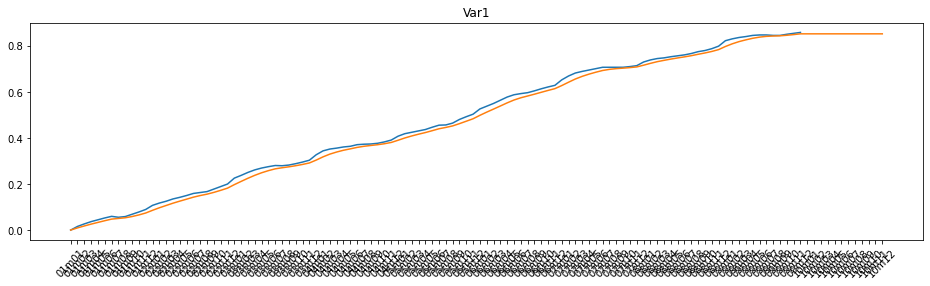

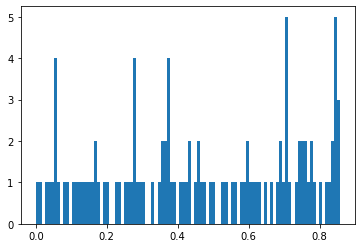

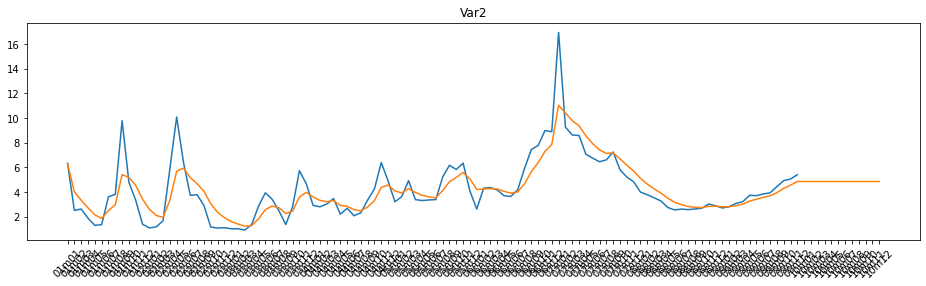

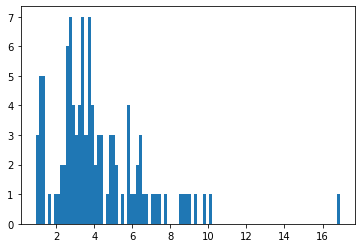

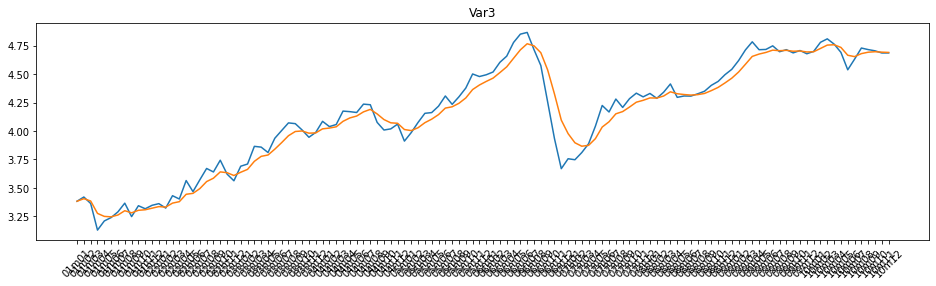

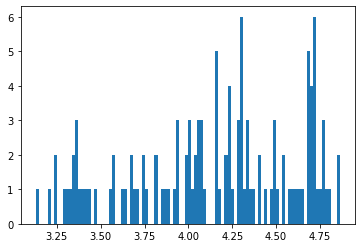

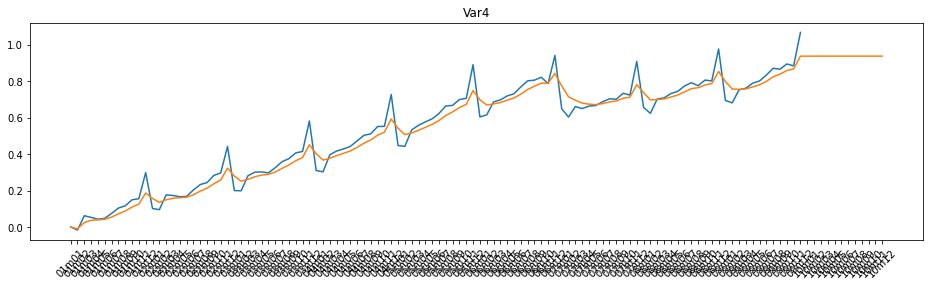

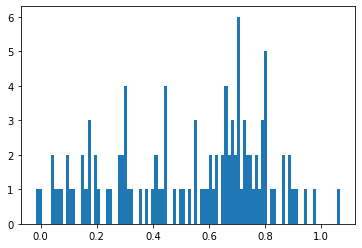

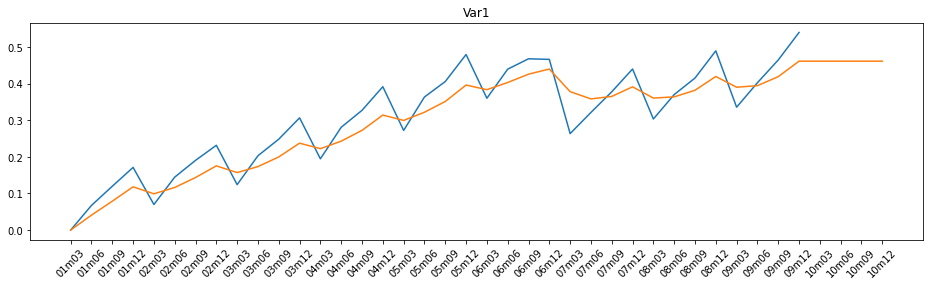

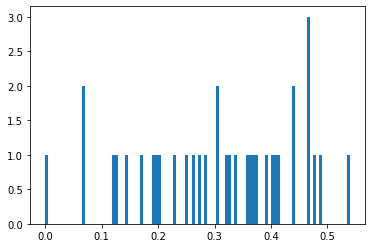

In [785]:
plot_every_col_m_test(dfd['Monthly'])
plot_every_col_m_test(dfd['Quarterly'])

# Обработка всех файлов


In [4]:
from lightgbm import LGBMRegressor

In [7]:
def predict_file(df, alpha_model, alpha_rb, alpha_ewm, lag_num, w_size_max, w_size_mean, samples_wd=0.01):
    alpha_model = alpha_model
    alpha_rb = alpha_rb
    alpha_ewm = alpha_ewm
    lag_num = lag_num
    w_size_max = w_size_max
    w_size_mean = w_size_mean
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        metrics = []
        predictions = []
        data_many_var = df.copy()
        for _col in data_many_var.columns:
            data = data_many_var[[_col]]
            data.columns = ["y"]
            if data.y.isna().sum() != 0:

                data['month'] = list(map(int, data.index.str[-2:]))
                for i in range(1,12+1):
                    col = 'RB' + str(i)
                    data[col] = data.month.apply(radial_basis, month=(i), alpha=alpha_rb)
                data=data.drop('month', axis=1)

                data_train = data.loc[~data.y.isna()]
                data_test = data.loc[data.y.isna()]

#                 data_train['ewm_mean_1'] = data_train.y.ewm(alpha=alpha_ewm).mean().shift(1)
#                 for i in list(range(1, lag_num+1)):
#                     data_train["lag_{}".format(i)] = data_train.y.shift(i)
#                 for i in list(range(1, lag_num+1)):
#                     data_train["max_{}".format(i)] = data_train.y.rolling(i).max()
#                 for i in list(range(1, lag_num+1)):
#                     data_train["mean_{}".format(i)] = data_train.y.rolling(i).mean()

                data_train = data_train.fillna(method='bfill')
                cols_to_test = data_train.columns[~data_train.columns.str.startswith('RB')][1:]
                data_test[cols_to_test] = data_train.iloc[-1,:][cols_to_test]
    #             data = data.dropna(axis=0)
                y_train = data_train.y
                X_train = data_train.drop(["y"], axis=1)
                X_test = data_test.drop(["y"], axis=1)

                lr = LGBMRegressor()
                decay = samples_wd
                train_weights = np.exp(np.linspace(len(X_train), 0, num=len(X_train))*-decay)
                lr.fit(X_train, 
                       y_train, 
                       sample_weight=train_weights
                      )
                prediction = lr.predict(X_test)
                predictions.append(prediction)
                
                data_many_var.loc[data_many_var[_col].isna(), _col] = prediction
        return data_many_var

In [71]:
~dfd['Monthly'].columns.str.startswith('RB')

array([ True,  True,  True,  True])

In [8]:
model_params = {'alpha_model': 0.0091,
 'alpha_rb': 0.4,
 'alpha_ewm': 0.35100000000000003,
 'lag_num': 15,
 'w_size_max': 3,
 'w_size_mean': 1}

In [ ]:
import os 
from tqdm import tqdm
import warnings
folder = "test_data/"
out_folder="test_data_out/"
dfd = {}

model_params['samples_wd'] = 0.9
model_params['alpha_rb'] = 11
model_params['lag_num'] = 24

for filepath in tqdm(os.listdir(folder)):
    out_filepath = os.path.join(out_folder,('Test_output_'+filepath.split('_')[-1]))
    if filepath[:4] == 'Test':
        test = pd.ExcelFile(os.path.join(folder, filepath))
        with pd.ExcelWriter(out_filepath) as writer:  
            for _sheet_name in test.sheet_names:
                df_sheet = test.parse(_sheet_name, index_col=0, na_values='Forecast').astype(float)
                df_sheet = predict_file(df_sheet, **model_params)
                df_sheet.to_excel(writer, sheet_name=_sheet_name)


  0%|▎                                                                               | 20/4446 [00:11<32:27,  2.27it/s]Exception ignored in: <function ZipFile.__del__ at 0x000002894D53C280>
Traceback (most recent call last):
  File "C:\Users\pqlet\AppData\Local\Programs\Python\Python39\lib\zipfile.py", line 1816, in __del__
    self.close()
  File "C:\Users\pqlet\AppData\Local\Programs\Python\Python39\lib\zipfile.py", line 1833, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file
 12%|█████████▌                                                                   | 553/4446 [04:53<1:17:14,  1.19s/it]